# Import libraries

In [2]:
# General
import pandas as pd
import numpy as np
import re
import csv
import itertools
import copy
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt

# for KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances
from sklearn.metrics import pairwise_distances

# for KeplerMapper
import kmapper as km
from kmapper.plotlyviz import *

from sklearn.preprocessing import *
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn import manifold
from sklearn.neighbors.kde import KernelDensity
from scipy.ndimage.filters import gaussian_filter1d
from sklearn.decomposition import TruncatedSVD

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objs as go

# our functions
from functions import *


# Import and pre-process data


In [3]:
# import data
data = pd.read_csv('./coinfections.csv')
data


,infection scenario,time point [hours],viral load lung [NP copies/100µg RNA],bacerial burden lung [CFU/mL],IFN-γ [pg/mL],TNF-α []pg/mL],MCP-1 [pg/mL],IL-6 [pg/mL],IFN-β [pg/mL],IL-22 [pg/mL],GM-CSF [pg/mL]
0,IAV,1.5,137060.100000,0,26094.528,99.456,427.392,2732.400,2464.848000,19.824000,251.088
1,IAV,1.5,73532.840000,0,20254.848,173.568,297.264,2874.336,5791.536000,25.344000,329.376
2,IAV,1.5,366501.800000,0,5433.400,190.400,165.750,5416.000,0.000000,373.450000,0.000
3,IAV,1.5,39985.850000,0,12923.100,163.840,408.900,3287.990,1794.920000,23.500000,0.000
4,IAV,1.5,181103.200000,0,4403.020,22.720,118.240,517.260,0.000000,0.000000,0.000
5,IAV,1.5,123001.300000,0,138.870,106.410,34.880,53.550,1227.570000,0.000000,50.730
6,IAV,1.5,180120.500000,0,122.540,103.630,28.320,24.960,1186.470000,0.000000,66.040
7,IAV,6.0,213540.000000,0,10348.200,49.810,191.200,3622.990,1329.920000,11.130000,86.170
8,IAV,6.0,189586.300000,0,7953.560,153.670,297.280,2213.060,1353.250000,10.780000,123.170
9,IAV,6.0,100488.200000,0,15170.020,142.070,221.890,2816.030,872.280000,9.210000,0.000


In [4]:
# delete the units from the columns names
cols = data.columns
columns_names = []
for i in np.arange(len(cols)):
    x = re.split('\n',cols[i])
    columns_names.append(x[0])

data.columns = columns_names  

# rename columns that have greek letters
data.rename(columns={'IFN-γ':'IFN-gamma', 'TNF-α':'TFN-alpha', 'IFN-β':'IFN-beta', 'infection scenario':'infection group', 'GM-CSF ':'GM-CSF', 'bacerial burden lung':'bacterial burden lung'}, inplace=True)


In [5]:
# define the features variable for future use
features = list(data.columns[1:])
features

['time point',
 'viral load lung',
 'bacterial burden lung',
 'IFN-gamma',
 'TFN-alpha',
 'MCP-1',
 'IL-6',
 'IFN-beta',
 'IL-22',
 'GM-CSF']

In [6]:
# define the features variable for future use
features_no_v = ['time point',
 'bacterial burden lung',
 'IFN-gamma',
 'TFN-alpha',
 'MCP-1',
 'IL-6',
 'IFN-beta',
 'IL-22',
 'GM-CSF']

In [7]:
features_no_b = ['time point',
 'viral load lung',
 'IFN-gamma',
 'TFN-alpha',
 'MCP-1',
 'IL-6',
 'IFN-beta',
 'IL-22',
 'GM-CSF']

In [8]:
# separate infection groups into different data frames
IAV = data[data['infection group']=='IAV']
IAV.drop(['infection group'], axis=1, inplace=True)
IAV.reset_index(drop=True, inplace=True)

T4 = data[data['infection group']=='T4']
T4.drop(['infection group'], axis=1, inplace=True)
T4.reset_index(drop=True, inplace=True)

IAVT4 = data[data['infection group']=='IAV + T4']
IAVT4.drop(['infection group'], axis=1, inplace=True)
IAVT4.reset_index(drop=True, inplace=True)


In [9]:
# labels as integers
labels_data = data['infection group'].apply(lambda x: 1 if x=='IAV' else (2 if x=='T4' else 3)).as_matrix()

labels_IAV = IAV['time point'].apply(lambda x: 1 if x==1.5 else (2 if x==6.0 else (3 if x==18.0 else(4 if x==26.0 else 5)))).as_matrix()

labels_T4 = T4['time point'].apply(lambda x: 1 if x==1.5 else (2 if x==6.0 else (3 if x==18.0 else(4 if x==26.0 else 5)))).as_matrix()

labels_IAVT4 = IAVT4['time point'].apply(lambda x: 1 if x==1.5 else (2 if x==6.0 else (3 if x==18.0 else(4 if x==26.0 else 5)))).as_matrix()


# Figure 5 - Topological Data Analysis (Mapper algorithm)

We used the Keppler-Mapper library to generate topological graphs of the four data sets.

Data set 1: `IAV` infection group

Data set 2: `T4` infection group

Data set 3: `IAV + T4` infection group 

Data set 4: all the infections groups put together

We use the following metric and lenses to generate simplicial complexes for each data set:

Metric = correlation coefficient

Lens 1 = distance to the first neighbour

Lens 2 = projection to one of the following features: viral load lung, bacterial burden lung, IFN-gamma, TFN-alpha, MCP-1, IL-6.
 
In total 6 simplicial complexes are generated for the data sets 1 and 4 and five simplicial complexes for the data sets 2 and 3.

Other parameter values such as the number of intervals for each lens and the percentage overlap were obtained from an extensive semi-unsupervised parameter value grid search; for details we refer the reader to the supplementary material.


## Generate simplicial complexes

In [10]:
# Initialize mapper
mapper = km.KeplerMapper()

### All infection groups (data set 4)

In [11]:
# define parameter values for the simplicial complexes.
feature_lenses = ["lens_{}".format(x) for x in features[1:7]]
hypercubes = [[1,13],[3,7],[5,3],[1,9],[5,3],[1,13]]
p_overlap = [[0.3,0.8],[0.8,0.7],[0.8,0.8],[0.2,0.8],[0.8,0.4],[0.3,0.8]]
parameter_values = list(zip(feature_lenses, hypercubes, p_overlap))
parameter_values

[('lens_viral load lung', [1, 13], [0.3, 0.8]),
 ('lens_bacterial burden lung', [3, 7], [0.8, 0.7]),
 ('lens_IFN-gamma', [5, 3], [0.8, 0.8]),
 ('lens_TFN-alpha', [1, 9], [0.2, 0.8]),
 ('lens_MCP-1', [5, 3], [0.8, 0.4]),
 ('lens_IL-6', [1, 13], [0.3, 0.8])]

In [12]:
# make data into np array
X = np.array(data[features[1:]])

# define lenses
lenses_features = def_lenses_features(data, features[1:])
lenses_nbrs = def_lenses_neighbours(data, features[1:], labels_data, metric = 'correlation')

for idx, vals in enumerate(parameter_values): 

    # Combine lenses
    lens = np.c_[lenses_nbrs['Neighbour_1'], lenses_features[vals[0]]]

    # construct simplicial complex
    scomplex = mapper.map(lens, 
                          X, 
                          cover=km.cover.Cover(n_cubes=[vals[1][0], vals[1][1]],perc_overlap=[vals[2][0], vals[2][1]]),
                          clusterer=DBSCAN(metric='correlation', eps=0.5, min_samples=1),
                          precomputed=False)


    # visualise
    path = "./data_{}.html".format(features[idx+1])

    meta_dict = {"PROJECTIONS":"[neighbour-1, {}]".format(features[idx+1]),
                     "n_cubes":"[{},{}]".format(vals[1][0], vals[1][1]),
                     "PERCENTAGE OVERLAP":"[{},{}]".format(vals[2][0], vals[2][1]),
                     "CLUSTERER":DBSCAN(metric='correlation', eps=0.5, min_samples=1),
                     "SCALER":"MinMaxScaler(reature_range=(0,1))"}

    _ = mapper.visualize(graph=scomplex, 
                     path_html=path, 
                     custom_meta=meta_dict,                    
    #                  custom_tooltips=labels_data, 
                     color_function=labels_data,
                     nbins=3, 
                     title="all infection groups - {}".format(features[idx+1]))


#### Analysis of the simplicial complexes of the data set consisting of all the infection groups, that have more than 1 connected component
We can specify how many connected components we want the simplicial complex to have. In this case we will save all simplicial complexes with between 6 and 1 connected components. 

(Warning: The following cell takes a long time to compute.)


In [ ]:
# make data into np array
X = np.array(data[features[1:]])

# define lenses
lenses_features = def_lenses_features(data, features[1:])
lenses_nbrs = def_lenses_neighbours(data, features[1:], labels_data, metric = 'correlation')

# define parameter values for the simplicial complexes.
hypercubes_1 = [1,3,5,7,9,11,13]
hypercubes_2 = [1,3,5,7,9,11,13]
p_overlap_1 = [0.1,0.3,0.5,0.7,0.9]
p_overlap_2 = [0.1,0.3,0.5,0.7,0.9]
eps = np.arange(0.1,2,0.2)
parameter_values = list(itertools.product(['Neighbour_1'], ['lens_IL-6'], 
                                          hypercubes_1, hypercubes_2, 
                                          p_overlap_1, p_overlap_2,
                                         eps))
df_temp = []
for idx, vals in enumerate(parameter_values):
    
    # Combine lenses and define other parameter values
    lens = np.c_[lenses_nbrs['Neighbour_1'], lenses_features['lens_IL-6']]      
    c1 = vals[2]
    c2 = vals[3]
    p1 = vals[4]
    p2 = vals[5]   
    eps = vals[6]

    # construct simplicial complex
    scomplex = mapper.map(lens, 
                          X, 
                          cover=km.cover.Cover(n_cubes=[c1,c2],perc_overlap=[p1,p2]),
                          clusterer=DBSCAN(metric='correlation', eps=eps, min_samples=1),
                          precomputed=False)
    
    # Calculate number of connected components
    n_v, n_cc = count_connected_components(scomplex)

    # Append data to list for dataframe only if the simplex has num_connected_components
    # or less connected components
    if n_cc <= 6:
        df_temp.append(['neighbour_1', 'IL-6', c1, c2, p1, p2, eps, n_v, n_cc])
                 
# Create dataframe
columns = ['lens1', 'lens2',  
           'lens1_n_cubes', 'lens2_n_cubes', 
           'lens1_perc_overlap', 'lens2_perc_overlap', 
           'eps', 'n_vertices', 'n_connected_components']
df_sc = pd.DataFrame(data=df_temp, columns=columns)

# save df to file
# df_sc.to_csv('./data_6_cc.csv')
                 

In [13]:
df_sc = pd.read_csv('data_6_cc.csv')

In [14]:
# inspect data frame
df_sc.describe()

,Unnamed: 0,lens1_n_cubes,lens2_n_cubes,lens1_perc_overlap,lens2_perc_overlap,eps,n_vertices,n_connected_components
count,8563.000000,8563.000000,8563.000000,8563.000000,8563.000000,8563.000000,8563.000000,8563.000000
mean,4281.000000,6.700572,6.048698,0.521394,0.589618,1.140476,26.987855,3.124489
std,2472.069511,3.983971,3.915940,0.281684,0.260968,0.525457,30.976679,1.585355
min,0.000000,1.000000,1.000000,0.100000,0.100000,0.100000,1.000000,1.000000
25%,2140.500000,3.000000,3.000000,0.300000,0.300000,0.700000,9.000000,2.000000
50%,4281.000000,7.000000,5.000000,0.500000,0.700000,1.100000,17.000000,3.000000
75%,6421.500000,11.000000,9.000000,0.700000,0.900000,1.500000,34.000000,4.000000
max,8562.000000,13.000000,13.000000,0.900000,0.900000,1.900000,403.000000,6.000000


In [15]:
# inspect simplicial complexes that consist of exactly 6 connected component
df_sc[df_sc['n_connected_components']==1].describe()

,Unnamed: 0,lens1_n_cubes,lens2_n_cubes,lens1_perc_overlap,lens2_perc_overlap,eps,n_vertices,n_connected_components
count,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.000000,1937.0
mean,2614.807434,4.049045,5.564791,0.694631,0.654053,1.318998,21.364481,1.0
std,2291.059285,3.549847,3.843673,0.262088,0.237444,0.446717,25.464879,0.0
min,2.000000,1.000000,1.000000,0.100000,0.100000,0.500000,1.000000,1.0
25%,727.000000,1.000000,3.000000,0.500000,0.500000,0.900000,5.000000,1.0
50%,1832.000000,3.000000,5.000000,0.900000,0.700000,1.300000,11.000000,1.0
75%,4156.000000,7.000000,9.000000,0.900000,0.900000,1.700000,28.000000,1.0
max,8562.000000,13.000000,13.000000,0.900000,0.900000,1.900000,156.000000,1.0


In [16]:
# choose simplicial complexes that consist of exactly 6 connected component
# sort simplicial complexes in ascending order by eps and percentage overlap of the lenses
to_plot = df_sc[df_sc['n_connected_components']==6].sort_values(by=['eps', 'lens1_perc_overlap', 'lens2_perc_overlap', 'n_vertices'])

# pick only the simplicial complexes that have at least 40 vertices
to_plot = to_plot[to_plot['n_vertices']>=40]
to_plot.reset_index(drop=True, inplace=True)
to_plot

,Unnamed: 0,lens1,lens2,lens1_n_cubes,lens2_n_cubes,lens1_perc_overlap,lens2_perc_overlap,eps,n_vertices,n_connected_components
0,918,neighbour_1,IL-6,1,9,0.1,0.9,0.1,45,6
1,2256,neighbour_1,IL-6,3,9,0.1,0.9,0.1,45,6
2,3550,neighbour_1,IL-6,5,9,0.1,0.9,0.1,45,6
3,1081,neighbour_1,IL-6,1,11,0.1,0.9,0.1,51,6
4,2406,neighbour_1,IL-6,3,11,0.1,0.9,0.1,51,6
5,3698,neighbour_1,IL-6,5,11,0.1,0.9,0.1,51,6
6,1235,neighbour_1,IL-6,1,13,0.1,0.9,0.1,58,6
7,2547,neighbour_1,IL-6,3,13,0.1,0.9,0.1,58,6
8,3830,neighbour_1,IL-6,5,13,0.1,0.9,0.1,58,6
9,3211,neighbour_1,IL-6,5,5,0.3,0.9,0.1,40,6


In [17]:
# export html files of the first 10 in the list above

# make data into np array
X = data[features[1:]].as_matrix()

# define lenses
lenses_features = def_lenses_features(data, features[1:])
lenses_nbrs = def_lenses_neighbours(data, features[1:], labels_data, metric = 'correlation')

# init mapper
mapper = km.KeplerMapper() 

for i in np.arange(0,10,1):
    
    lens = np.c_[lenses_nbrs['Neighbour_1'], lenses_features['lens_IL-6']]      
    c1 = to_plot.loc[i,'lens1_n_cubes']
    c2 = to_plot.loc[i,'lens2_n_cubes']
    p1 = to_plot.loc[i,'lens1_perc_overlap']
    p2 = to_plot.loc[i,'lens2_perc_overlap']
    eps = to_plot.loc[i,'eps']

    # create complex
    scomplex = mapper.map(lens, 
                          X, 
                          cover=km.cover.Cover(n_cubes=[c1,c2],perc_overlap=[p1,p2]),
                          clusterer=DBSCAN(metric='correlation', eps=eps, min_samples=1),
                          precomputed=False)
    
    meta_dict = {"PROJECTIONS":"[neighbour-1, IL-6]",
                     "n_cubes":"[{},{}]".format(c1,c2),
                     "PERCENTAGE OVERLAP":"[{},{}]".format(p1,p2),
                     "CLUSTERER":DBSCAN(metric='correlation', eps=eps, min_samples=1),
                     "SCALER":"MinMaxScaler(reature_range=(0,1))"}

    title = "data_6cc_{}.html".format(i)
    path = "./" + title
    _ = mapper.visualize(graph=scomplex, 
                     path_html=path, 
                     custom_meta=meta_dict,                    
#                      custom_tooltips=labels_data,
                     color_function=labels_data,
                     nbins=len(np.unique(labels_data)), 
                     title=title)



### IAV (data set 1)

In [18]:
# define parameter values for the simplicial complexes.
feature_lenses = ["lens_{}".format(x) for x in features_no_b[1:7]]
hypercubes = [[1,13],[3,3],[3,3],[1,9],[3,3]]
p_overlap = [[0.2,0.8],[0.6,0.8],[0.8,0.7],[0.2,0.8],[0.6,0.8]]
parameter_values = list(zip(feature_lenses, hypercubes, p_overlap))
parameter_values

[('lens_viral load lung', [1, 13], [0.2, 0.8]),
 ('lens_IFN-gamma', [3, 3], [0.6, 0.8]),
 ('lens_TFN-alpha', [3, 3], [0.8, 0.7]),
 ('lens_MCP-1', [1, 9], [0.2, 0.8]),
 ('lens_IL-6', [3, 3], [0.6, 0.8])]

In [19]:
# make data into np array
X = np.array(IAV[features[1:]])

# define lenses
lenses_features = def_lenses_features(IAV, features_no_b[1:])
lenses_nbrs = def_lenses_neighbours(IAV, features_no_b[1:], labels_IAV, metric = 'correlation')

for idx, vals in enumerate(parameter_values): 

    # Combine lenses
    lens = np.c_[lenses_nbrs['Neighbour_1'], lenses_features[vals[0]]]

    # construct simplicial complex
    scomplex = mapper.map(lens, 
                          X, 
                          cover=km.cover.Cover(n_cubes=[vals[1][0], vals[1][1]],perc_overlap=[vals[2][0], vals[2][1]]),
                          clusterer=DBSCAN(metric='correlation', eps=0.5, min_samples=1),
                          precomputed=False)


    # visualise
    path = "./IAV_{}.html".format(features_no_b[idx+1])

    meta_dict = {"PROJECTIONS":"[neighbour-1, {}]".format(features_no_b[idx+1]),
                     "n_cubes":"[{},{}]".format(vals[1][0], vals[1][1]),
                     "PERCENTAGE OVERLAP":"[{},{}]".format(vals[2][0], vals[2][1]),
                     "CLUSTERER":DBSCAN(metric='correlation', eps=0.5, min_samples=1),
                     "SCALER":"MinMaxScaler(reature_range=(0,1))"}

    _ = mapper.visualize(graph=scomplex, 
                     path_html=path, 
                     custom_meta=meta_dict,                    
    #                  custom_tooltips=labels_IAV, 
                     color_function=labels_IAV,
                     nbins=5, 
                     title="IAV - {}".format(features_no_b[idx+1]))



### T4 (data set 2)

In [20]:
# define parameter values for the simplicial complexes.
feature_lenses = ["lens_{}".format(x) for x in features_no_v[1:7]]
hypercubes = [[3,3],[3,3],[1,13],[3,3],[3,3]]
p_overlap = [[0.7,0.8],[0.7,0.8],[0.2,0.8],[0.7,0.8],[0.7,0.8]]
parameter_values = list(zip(feature_lenses, hypercubes, p_overlap))
parameter_values

[('lens_bacterial burden lung', [3, 3], [0.7, 0.8]),
 ('lens_IFN-gamma', [3, 3], [0.7, 0.8]),
 ('lens_TFN-alpha', [1, 13], [0.2, 0.8]),
 ('lens_MCP-1', [3, 3], [0.7, 0.8]),
 ('lens_IL-6', [3, 3], [0.7, 0.8])]

In [21]:
# make data into np array
X = np.array(T4[features[1:]])

# define lenses
lenses_features = def_lenses_features(T4, features_no_v[1:])
lenses_nbrs = def_lenses_neighbours(T4, features_no_v[1:], labels_T4, metric = 'correlation')

for idx, vals in enumerate(parameter_values): 

    # Combine lenses
    lens = np.c_[lenses_nbrs['Neighbour_1'], lenses_features[vals[0]]]

    # construct simplicial complex
    scomplex = mapper.map(lens, 
                          X, 
                          cover=km.cover.Cover(n_cubes=[vals[1][0], vals[1][1]],perc_overlap=[vals[2][0], vals[2][1]]),
                          clusterer=DBSCAN(metric='correlation', eps=1.1, min_samples=1),
                          precomputed=False)


    # visualise
    path = "./T4_{}.html".format(features_no_v[idx+1])

    meta_dict = {"PROJECTIONS":"[neighbour-1, {}]".format(features_no_v[idx+1]),
                     "n_cubes":"[{},{}]".format(vals[1][0], vals[1][1]),
                     "PERCENTAGE OVERLAP":"[{},{}]".format(vals[2][0], vals[2][1]),
                     "CLUSTERER":DBSCAN(metric='correlation', eps=1.1, min_samples=1),
                     "SCALER":"MinMaxScaler(reature_range=(0,1))"}

    _ = mapper.visualize(graph=scomplex, 
                     path_html=path, 
                     custom_meta=meta_dict,                    
    #                  custom_tooltips=labels_T4, 
                     color_function=labels_T4,
                     nbins=5, 
                     title="T4 - {}".format(features_no_v[idx+1]))




### IAV + T4 (data set 3)

In [22]:
# define parameter values for the simplicial complexes.
feature_lenses = ["lens_{}".format(x) for x in features[1:7]]
hypercubes = [[1,13],[3,7],[3,3],[5,3],[3,3],[3,3]]
p_overlap = [[0.3,0.8],[0.7,0.7],[0.8,0.7],[0.8,0.6],[0.8,0.4],[0.8,0.5]]
eps = [0.5,0.5,0.5,0.5,0.5,0.7]
parameter_values = list(zip(feature_lenses, hypercubes, p_overlap, eps))
parameter_values

[('lens_viral load lung', [1, 13], [0.3, 0.8], 0.5),
 ('lens_bacterial burden lung', [3, 7], [0.7, 0.7], 0.5),
 ('lens_IFN-gamma', [3, 3], [0.8, 0.7], 0.5),
 ('lens_TFN-alpha', [5, 3], [0.8, 0.6], 0.5),
 ('lens_MCP-1', [3, 3], [0.8, 0.4], 0.5),
 ('lens_IL-6', [3, 3], [0.8, 0.5], 0.7)]

In [23]:
# make data into np array
X = np.array(IAVT4[features[1:]])

# define lenses
lenses_features = def_lenses_features(IAVT4, features[1:])
lenses_nbrs = def_lenses_neighbours(IAVT4, features[1:], labels_IAVT4, metric = 'correlation')

for idx, vals in enumerate(parameter_values): 

    # Combine lenses
    lens = np.c_[lenses_nbrs['Neighbour_1'], lenses_features[vals[0]]]

    # construct simplicial complex
    scomplex = mapper.map(lens, 
                          X, 
                          cover=km.cover.Cover(n_cubes=[vals[1][0], vals[1][1]],perc_overlap=[vals[2][0], vals[2][1]]),
                          clusterer=DBSCAN(metric='correlation', eps=vals[-1], min_samples=1),
                          precomputed=False)


    # visualise
    path = "./IAVT4_{}.html".format(features[idx+1])

    meta_dict = {"PROJECTIONS":"[neighbour-1, {}]".format(features[idx+1]),
                     "n_cubes":"[{},{}]".format(vals[1][0], vals[1][1]),
                     "PERCENTAGE OVERLAP":"[{},{}]".format(vals[2][0], vals[2][1]),
                     "CLUSTERER":DBSCAN(metric='correlation', eps=vals[-1], min_samples=1),
                     "SCALER":"MinMaxScaler(reature_range=(0,1))"}

    _ = mapper.visualize(graph=scomplex, 
                     path_html=path, 
                     custom_meta=meta_dict,                    
    #                  custom_tooltips=labels_IAVT4, 
                     color_function=labels_IAVT4,
                     nbins=5, 
                     title="IAVT4 - {}".format(features[idx+1]))





# Figure 4 - Correlation distance matrix analysis and nearest neighbour analysis

## Correlation distance matrices

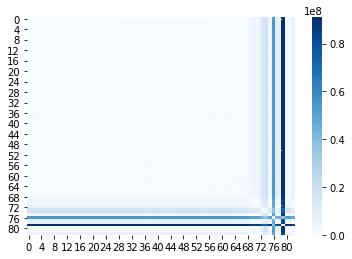

In [24]:
# eucidean distances matrix
eucl_dist = pairwise_distances(data[features[1:]], metric='euclidean')
sns.heatmap(eucl_dist, cmap='Blues')
# plt.savefig('./euclidean_distances_matrix')


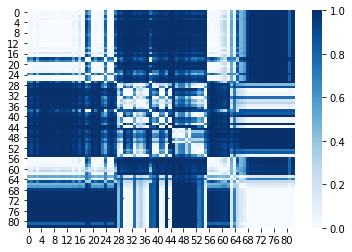

In [25]:
# cosine distance matrix
cos_dist = pairwise_distances(data[features[1:]], metric='cosine')
sns.heatmap(cos_dist, cmap='Blues')
# plt.savefig('./distances_matrix_cosine.png')


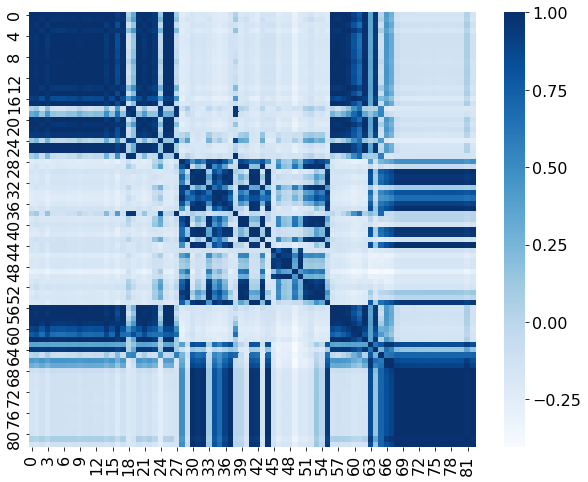

In [14]:
# correlation distance matrix
#corr_dist = pairwise_distances(data[features[1:]], metric='correlation')
corr_dist = np.corrcoef(data[features[1:]])
fig, ax = plt.subplots(figsize=(10,8))
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)    
sns.heatmap(corr_dist, cmap='Blues', ax=ax)
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=16)
plt.savefig('./distances_matrix_correlation.pdf', format='pdf')


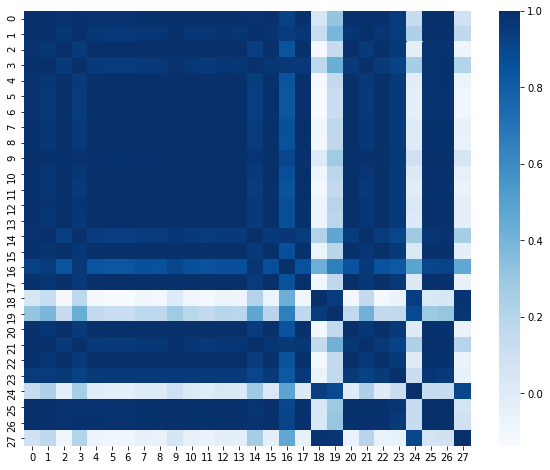

In [13]:
# correlation distance matrix
#corr_dist_IAV = pairwise_distances(IAV[features[1:]], metric='correlation')
corr_dist_IAV = np.corrcoef(IAV[features[1:]])
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(corr_dist_IAV, cmap='Blues')
plt.savefig('./distances_matrix_correlation_IAV.png')


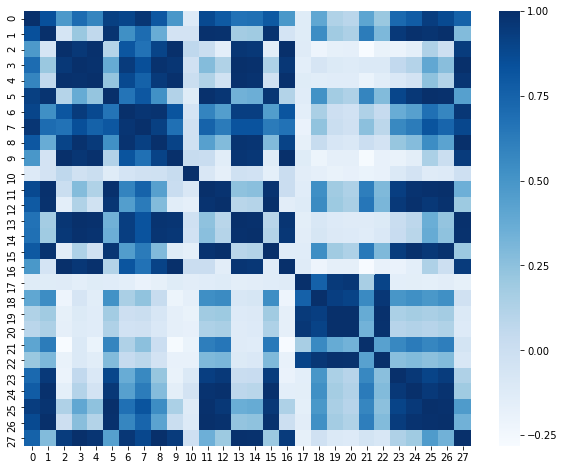

In [12]:
# correlation distance matrix
#corr_dist_T4 = pairwise_distances(T4[features[1:]], metric='correlation')
corr_dist_T4 = np.corrcoef(T4[features[1:]])
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(corr_dist_T4, cmap='Blues')
plt.savefig('./distances_matrix_correlation_T4.png')


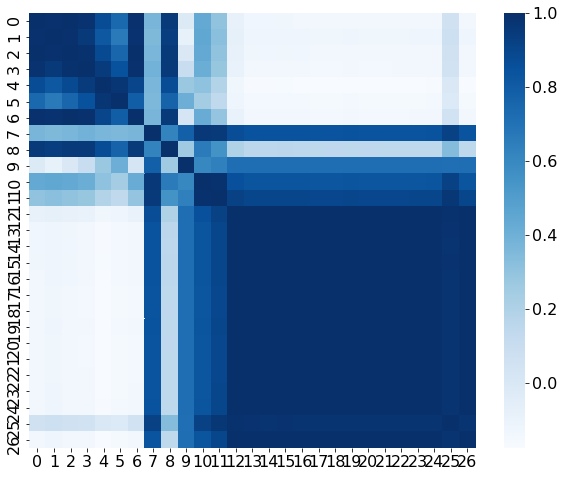

In [11]:
# correlation distance matrix
#corr_dist_IAVT4 = pairwise_distances(IAVT4[features[1:]], metric='correlation')
corr_dist_IAVT4 = np.corrcoef(IAVT4[features[1:]])
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(corr_dist_IAVT4, cmap='Blues', ax=ax)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)    
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=16)
plt.savefig('./distances_matrix_correlation_IAVT4.pdf', format='pdf')


#### Observations
The cosine and correlation distances matrix reveal the same structure of the data set, therefore we could use either of them, but it is easier to interpret the correlation distance between two points than the cosine distance, in the context of infection. Therefore we choose the correlation distance and metric for TDA done above.

## Nearest neighbour matrices


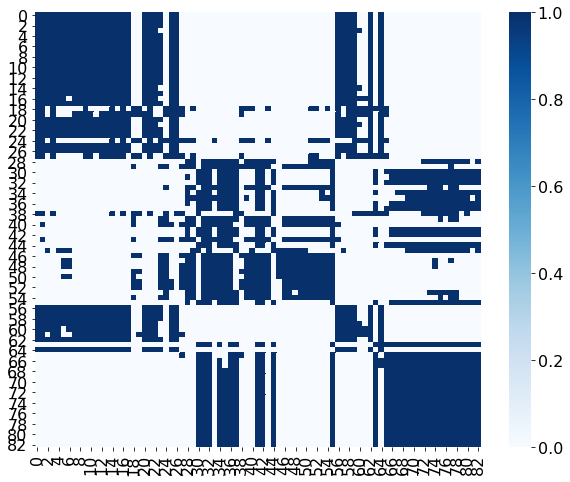

In [30]:
# matrix of 30 nearest neghbours

neighcd = KNeighborsClassifier(n_neighbors=30, weights='distance', algorithm='brute', metric='precomputed')

neighcd.fit(corr_dist, labels_data) 

Acd = neighcd.kneighbors_graph(corr_dist, mode='connectivity')

Acd = np.array(Acd.toarray(), dtype=bool)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(Acd, cmap='Blues', ax=ax)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(16)    
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=16)

plt.savefig('./knn_correlation_30_nearest_neighbors.pdf', format='pdf')


#### Observations

- Many of the data points (accross all time points) in the IAV infection group are connected to early data points in the co-infection group. 
- Many early data points in the T4 infection group are connected to late data points in the co-infection group.


## Box plots of groups identified in nearest neighbour matrix - Not shown in scripts
Below we divide the data set into three groups:

G1: IAV connected with IAV + T4

G2: T4 connected with IAV + T4

G3: IAV + T4 at 18hpc

and we make boxplots to compare the groups per feature (rows) per time point (rows).


In [31]:
# find all the connections of IAV points
IAV_connections = np.argwhere(Acd[:28,:])

# find all the connections of T4 points
T4_connections = np.argwhere(Acd[28:56,:])
T4_connections[:,0] = T4_connections[:,0] + np.ones(len(T4_connections))*28

# find all the connections of IAVT4 points
IAVT4_connections = np.argwhere(Acd[56:,:])
IAVT4_connections[:,0] = IAVT4_connections[:,0] + np.ones(len(IAVT4_connections))*56


In [32]:
# find indices of the points in IAV and the indices of the points in IAVT4 to which they are connected
IAV_IAVT4 = []
for i,j in enumerate(IAV_connections[:,1]>55):
    if j:
        IAV_IAVT4.append([IAV_connections[i,0],IAV_connections[i,1]])
IAV_IAVT4 = np.array(IAV_IAVT4)

# find the indices of the points in IAV and the indices of the points in T4 to which they are connected
IAV_T4 = []
for i,j in enumerate(np.logical_and(IAV_connections[:,1]>=29 ,IAV_connections[:,1]<=55)):
    if j:
        IAV_T4.append([IAV_connections[i,0],IAV_connections[i,1]])
IAV_T4 = np.array(IAV_T4)        


In [33]:
# find the indices of the points in T4 and the indices of the points in IAVT4 to which they are connected
T4_IAVT4 = []
for i,j in enumerate(T4_connections[:,1]>55):
    if j:
        T4_IAVT4.append([T4_connections[i,0],T4_connections[i,1]])
T4_IAVT4 = np.array(T4_IAVT4)

# find the indices of the points in T4 and the indices of the points in IAV to which they are connected
T4_IAV = []
for i,j in enumerate(T4_connections[:,1]<28):
    if j:
        T4_IAV.append([T4_connections[i,0],T4_connections[i,1]])
T4_IAV = np.array(T4_IAV)


In [34]:
# find the indices of the points in IAVT4 and the indices of the points in IAV to which they are connected
IAVT4_IAV = []
for i,j in enumerate(IAVT4_connections[:,1]<28):
    if j:
        IAVT4_IAV.append([IAVT4_connections[i,0],IAVT4_connections[i,1]])
IAVT4_IAV = np.array(IAVT4_IAV)

# find the indices of the points in IAVT4 and the indices of the points in T4 to which they are connected
IAVT4_T4 = []
for i,j in enumerate(np.logical_and(IAVT4_connections[:,1]>=29 ,IAVT4_connections[:,1]<=55)):
    if j:
        IAVT4_T4.append([IAVT4_connections[i,0],IAVT4_connections[i,1]])
IAVT4_T4 = np.array(IAVT4_T4)

In [35]:
# collect neighbours into three data frames

# G1
IAV_IAVT4_df = data.loc[np.unique(np.concatenate((np.unique(IAV_IAVT4[:,0]),np.unique(IAV_IAVT4[:,1]),np.unique(IAVT4_IAV[:,0]),np.unique(IAVT4_IAV[:,1])))),:]

# G2
T4_IAVT4_df = data.loc[np.unique(np.concatenate((np.unique(IAVT4_T4[:,0]),np.unique(IAVT4_T4[:,1]),np.unique(T4_IAVT4[:,0]),np.unique(T4_IAVT4[:,1])))),:]

# G3
G3 = IAVT4[IAVT4['time point']==18]

# for completion
# IAV_T4_df = data.loc[np.unique(np.concatenate((np.unique(IAV_T4[:,0]),np.unique(IAV_T4[:,1]),np.unique(T4_IAV[:,0]),np.unique(T4_IAV[:,1])))),:]


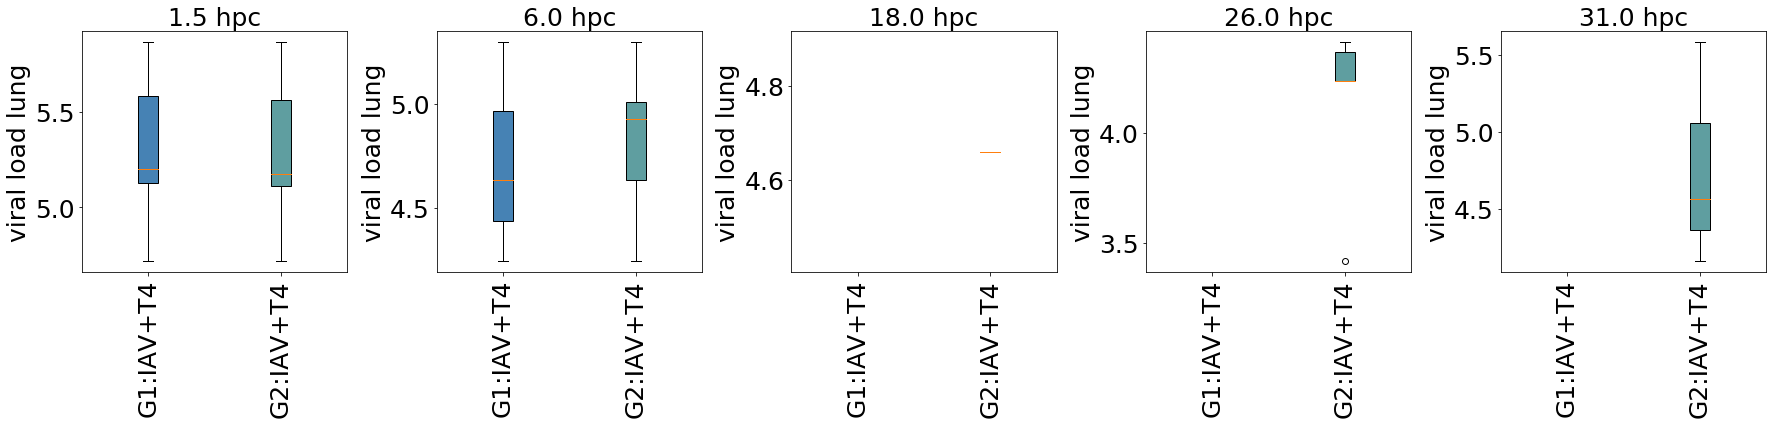

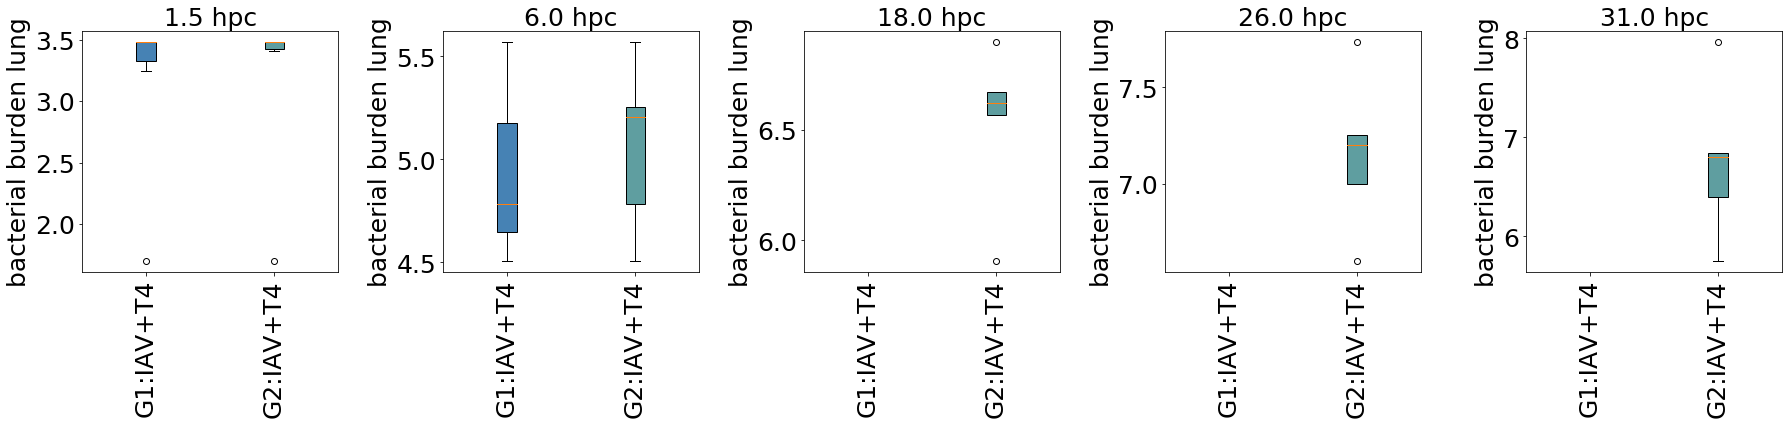

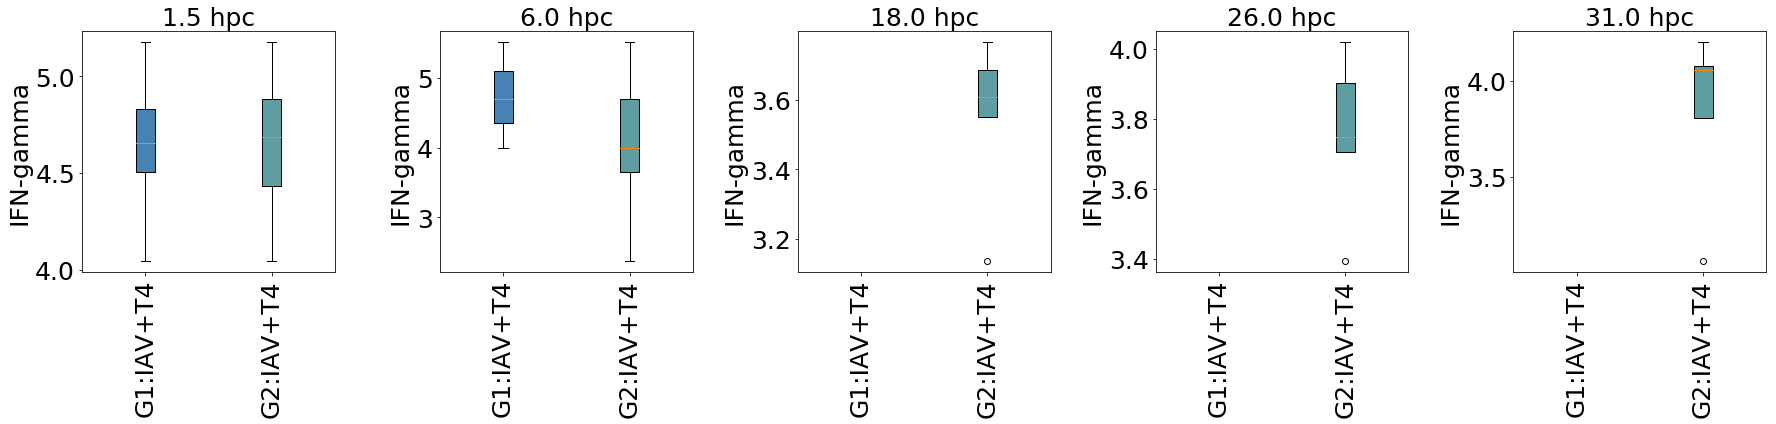

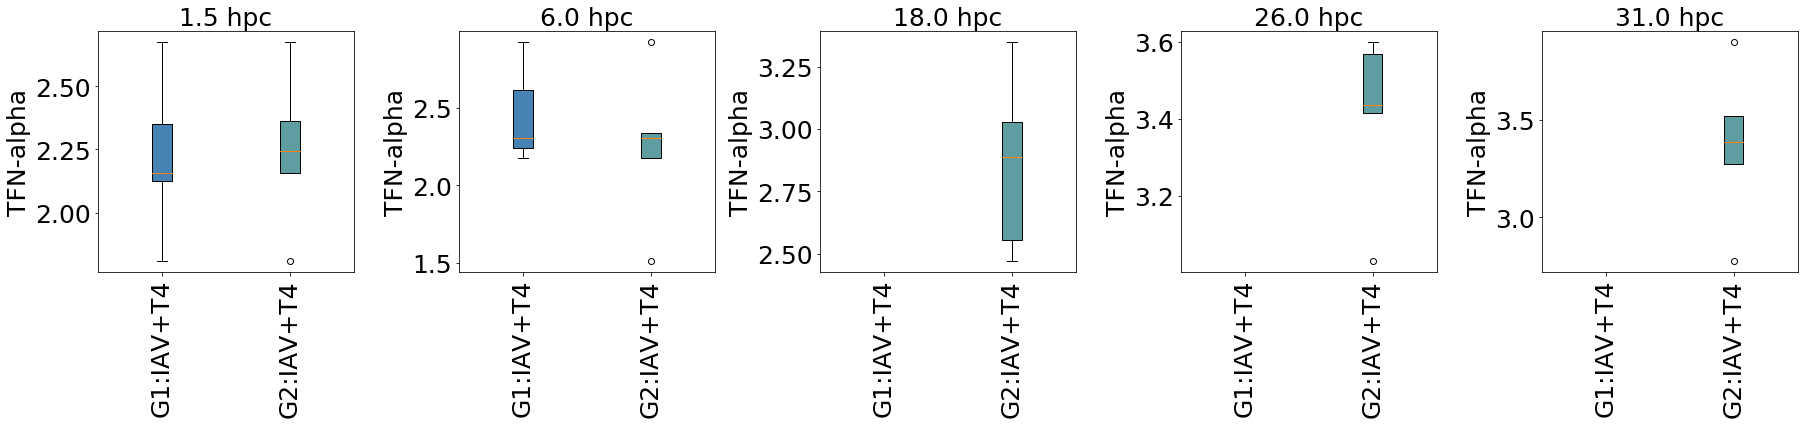

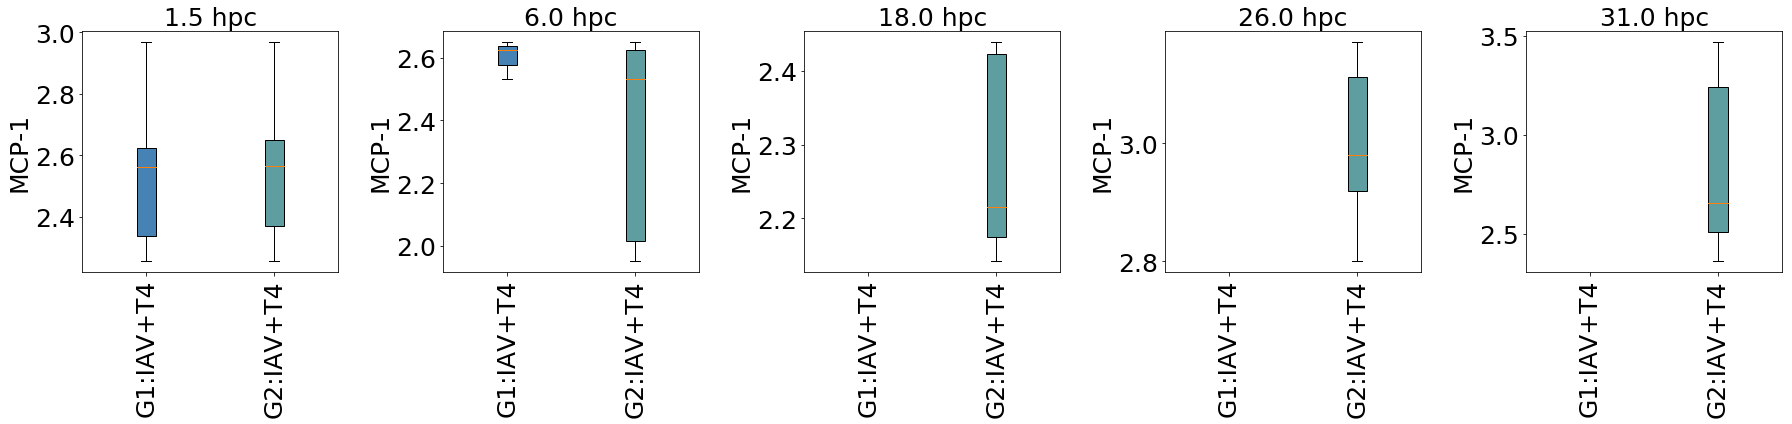

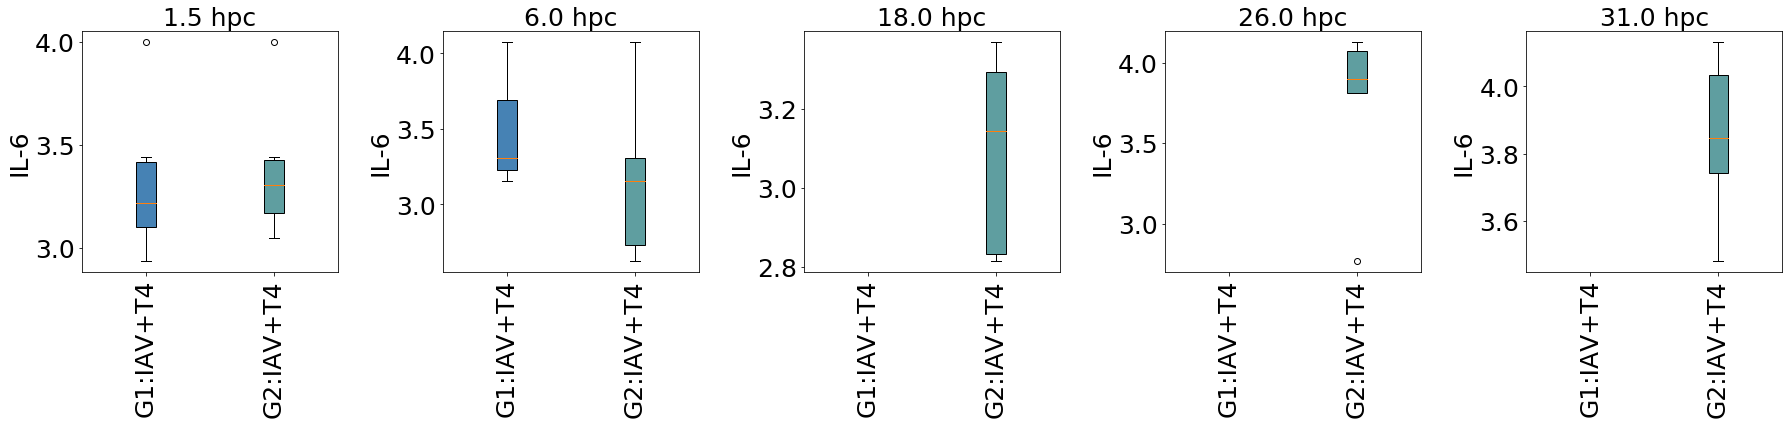

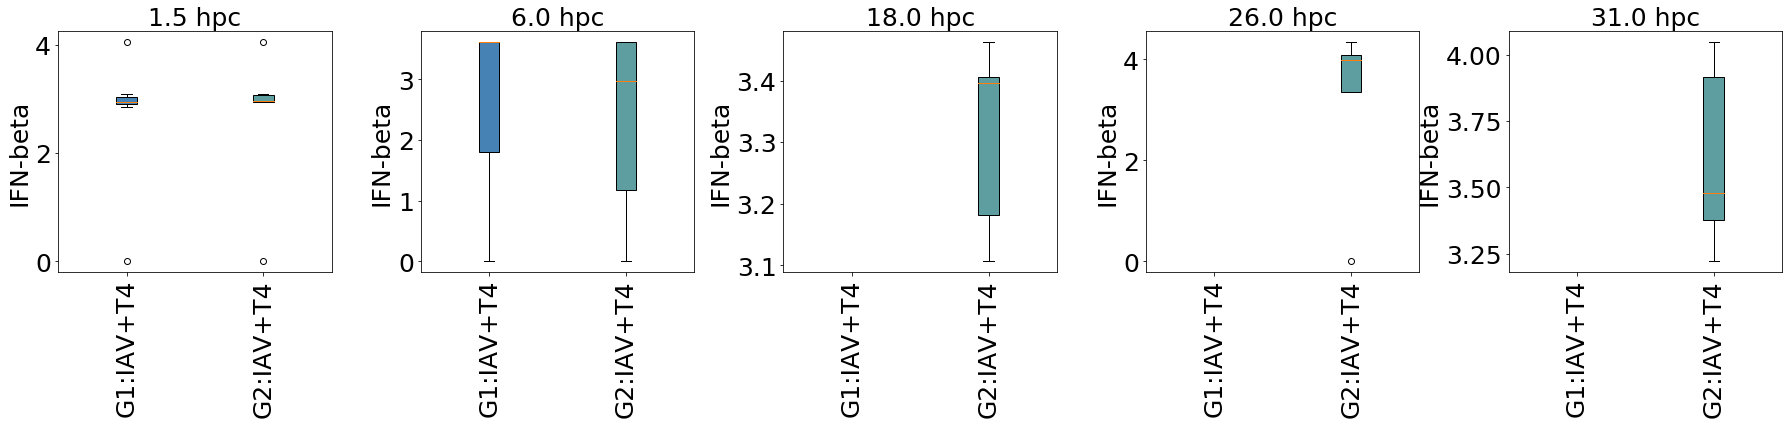

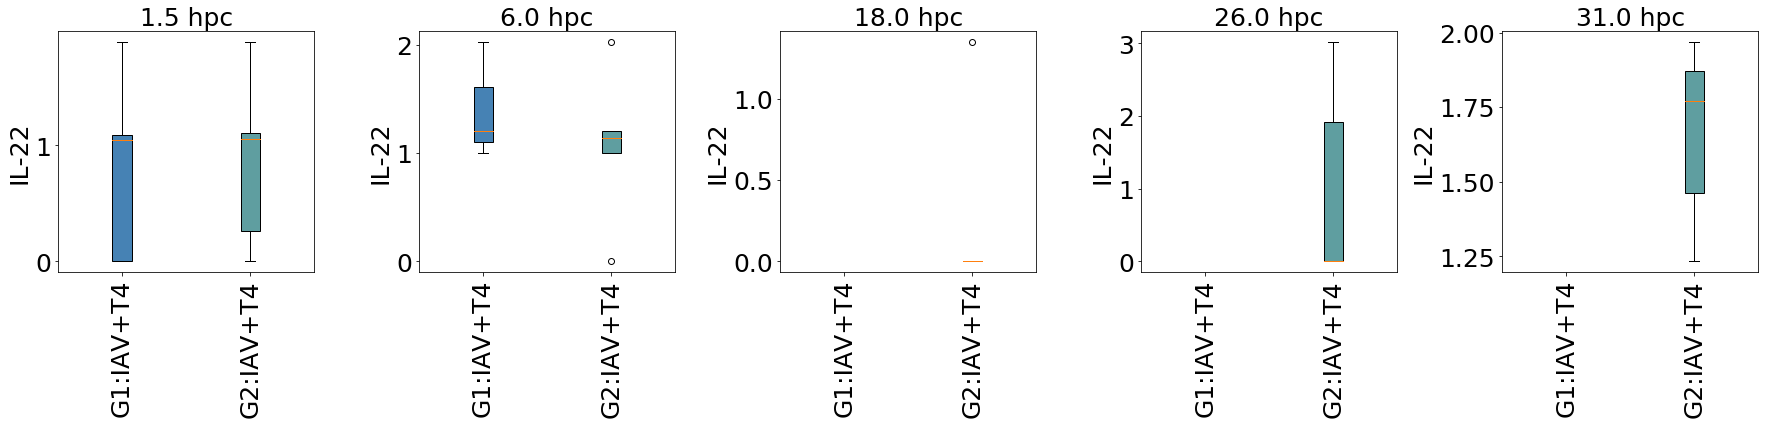

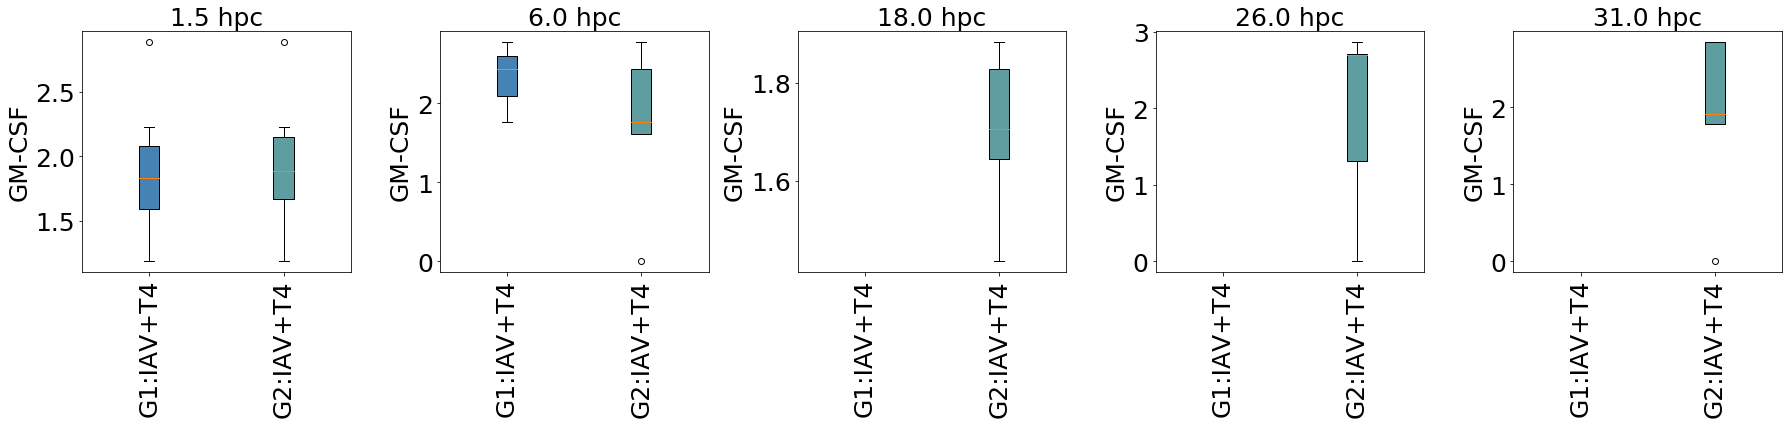

In [36]:
# box plots of IAVT4 points that are connected to IAV or T4 in distance matrix, per time point, per feature

for i,col in enumerate(features[1:]):

    IAVT4_IAV_temp = IAV_IAVT4_df.loc[56:,:] # IAVT4 connected to IAV
    IAVT4_T4_temp = T4_IAVT4_df.loc[56:,:] # IAVT4 connected to T4
    
    fig, axs = plt.subplots(1, len(data['time point'].unique()), figsize=(25,6))
    
    for timeidx, time in enumerate(data['time point'].unique()):

        # define data to plot
        a = np.log10(IAVT4_IAV_temp[IAVT4_IAV_temp['time point']==time][col])
        b = np.log10(IAVT4_T4_temp[IAVT4_T4_temp['time point']==time][col])
        
            # make -inf from log10 a very small number
        a[np.isinf(a)] = 1*10**(-300)
        b[np.isinf(b)] = 1*10**(-300)
        
        data_to_plot = [a,b]
    
        # box plot
        bplot = axs[timeidx].boxplot(data_to_plot, patch_artist=True)

        for patch, color in zip(bplot['boxes'], ['steelblue','cadetblue']):
            patch.set_facecolor(color)

        axs[timeidx].set_xticklabels(['G1:IAV+T4', 'G2:IAV+T4'], rotation='vertical', fontsize=25)
        axs[timeidx].set_ylabel('{}'.format(col), fontsize=25)
        axs[timeidx].set_title("{} hpc".format(time), fontsize=25)
        axs[timeidx].yaxis.set_tick_params(labelsize=25)

    plt.tight_layout()
    plt.savefig('./boxplot_nearest_neighbours_{}'.format(col))

Note that at 18hpc, viral load and IL-22 do not have a bar - this is because in viral load the data was missing and in IL-22 most of the ponts are 0.

# Supplementary Figure - Time series plots

In [37]:
IAV_means = calc_mean2(IAV, features[1:])
T4_means = calc_mean2(T4, features[1:])
IAVT4_means = calc_mean2(IAVT4, features[1:])


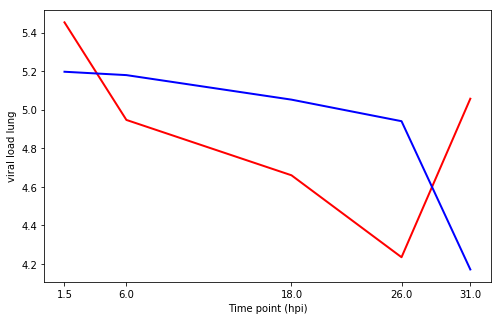

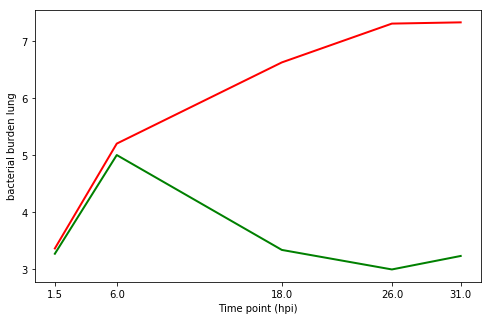

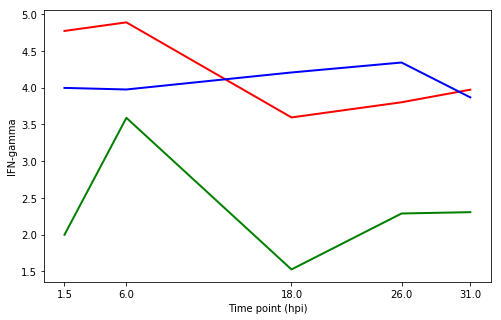

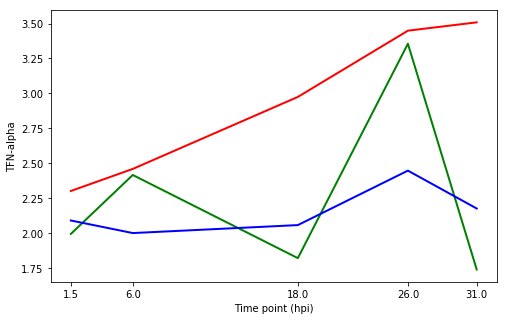

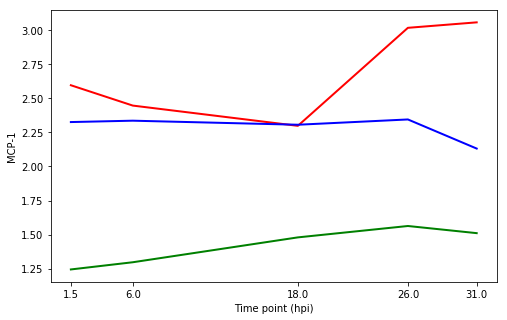

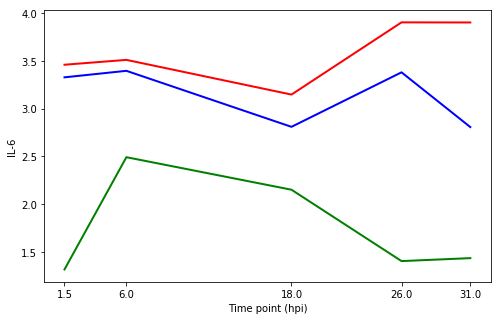

In [38]:
# Time series plot for the three infection groups

for idx, feature in enumerate(features[1:7]):
    plt.figure(figsize=(8,5))
    plt.xlabel('Time point (hpi)')
    plt.xticks(data['time point'].unique().tolist())
    plt.ylabel("{}".format(feature))
    plt.plot(IAVT4_means['time point'], np.log10(IAVT4_means[feature]), 'r-', linewidth=2, label='IAVT4_{}'.format(feature))
    plt.plot(T4_means['time point'], np.log10(T4_means[feature]), 'g-', linewidth=2, label='T4_{}'.format(feature))
    plt.plot(IAV_means['time point'], np.log10(IAV_means[feature]), 'b-', linewidth=2, label='IAV_{}'.format(feature))
#     plt.legend()
#     plt.savefig('./time_series_{}'.format(feature),  bbox_inches='tight')


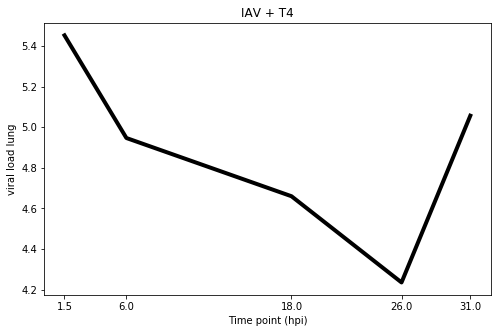

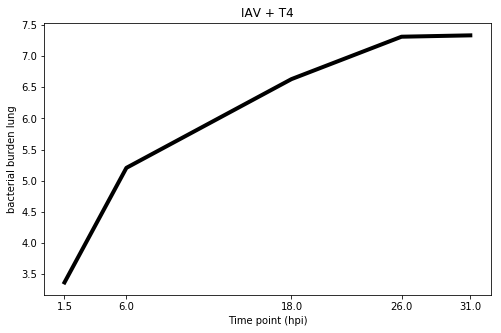

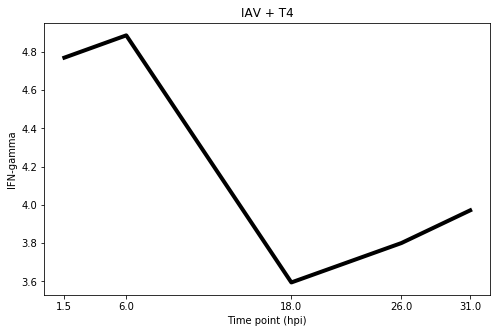

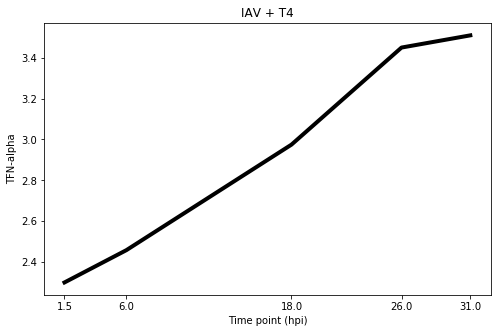

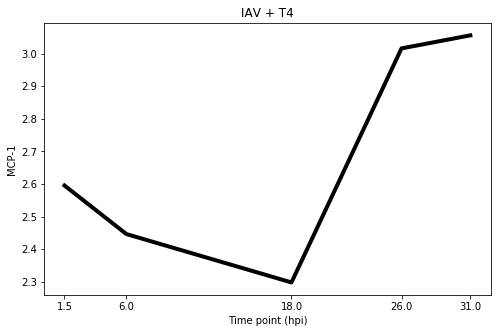

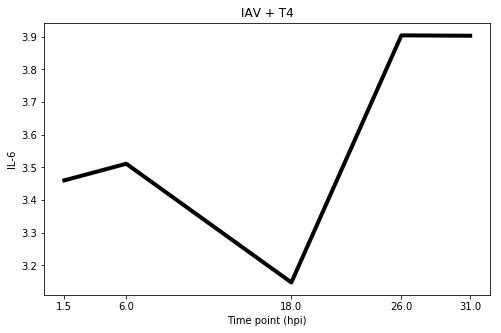

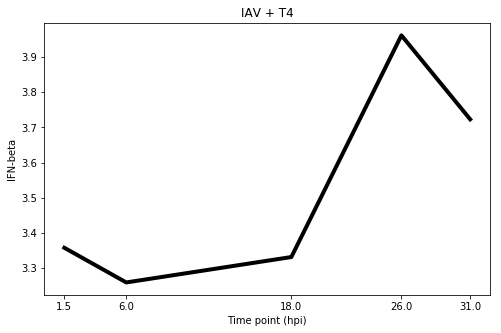

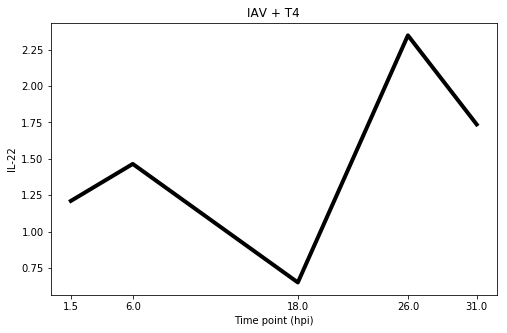

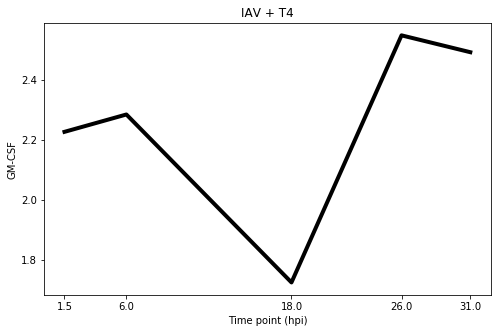

In [39]:
# Time series plot for the IAV + T4 infection group

for idx, feature in enumerate(features[1:]):
    plt.figure(figsize=(8,5))
    plt.xlabel('Time point (hpi)')
    plt.ylabel("{}".format(feature))
    plt.xticks(data['time point'].unique().tolist())
    plt.title('IAV + T4')
    plt.plot(IAVT4_means['time point'], np.log10(IAVT4_means[feature]), 'k-', label="{} mean".format(feature), linewidth=4)
    plt.savefig('./time_series_IAVT4_{}'.format(feature),  bbox_inches='tight')


# Supplementary Figure - Phase space Analysis
In the images below, points plotted correspond to the mean value at each time point and the bold black lines connect consecutive time points. The gray dashed lines connect the first and the last time points.


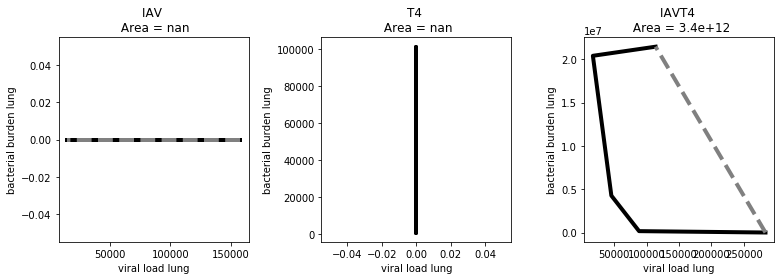

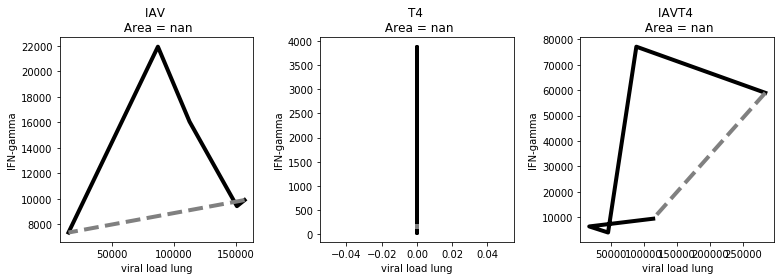

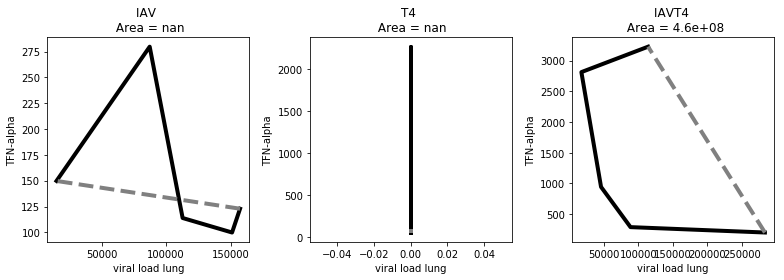

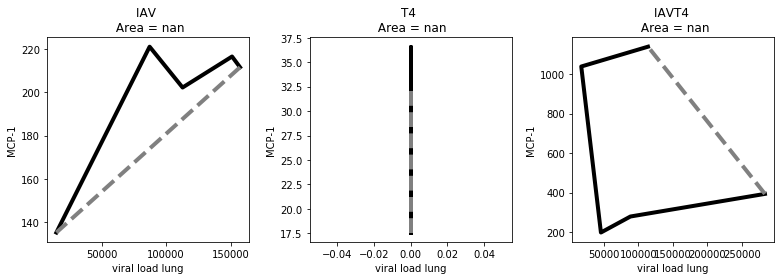

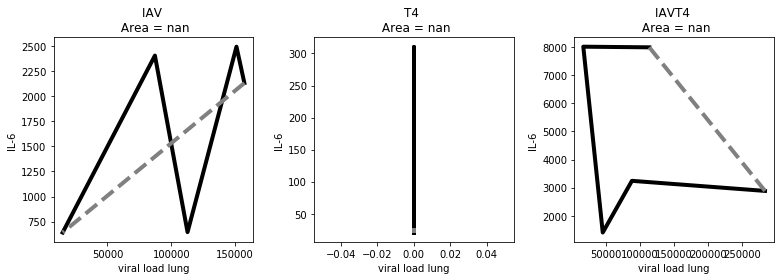

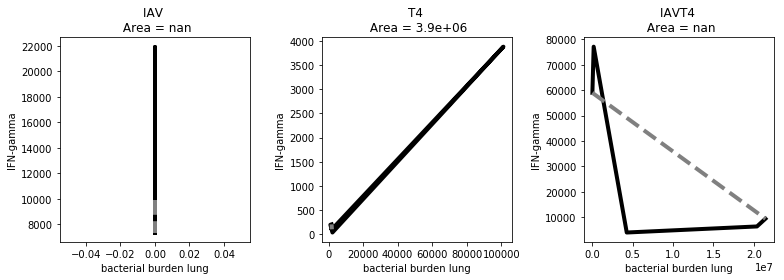

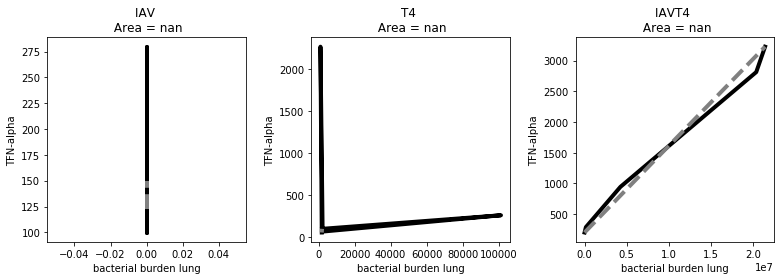

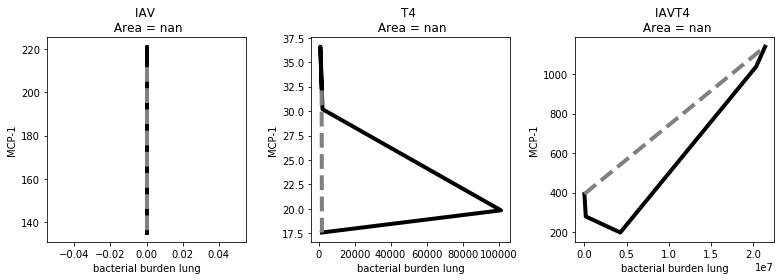

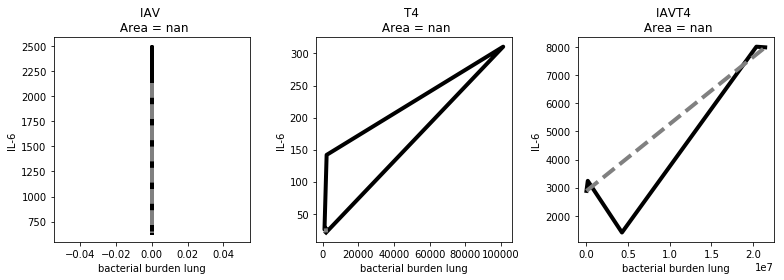

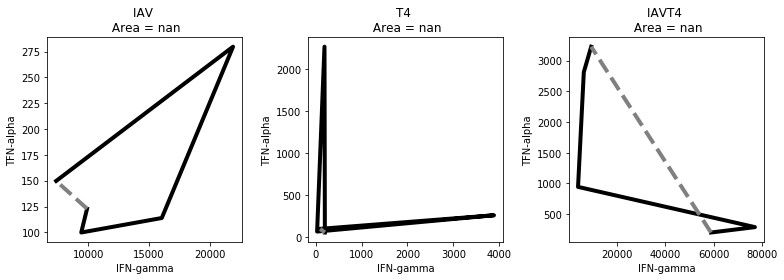

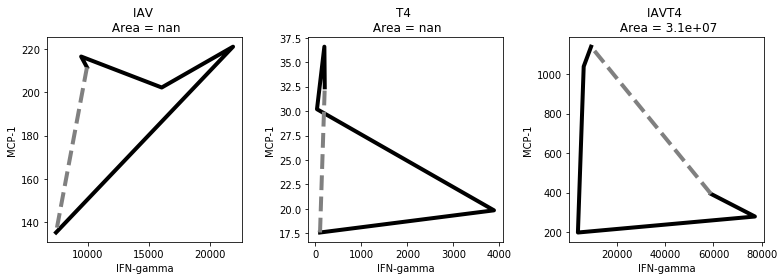

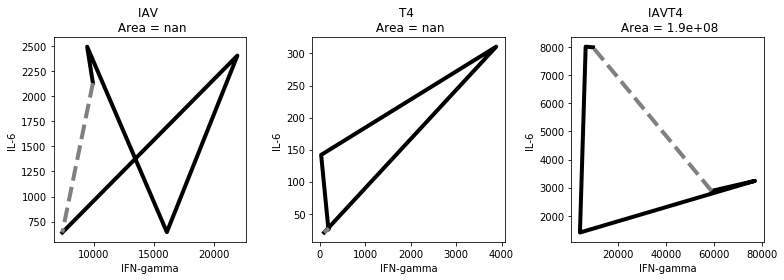

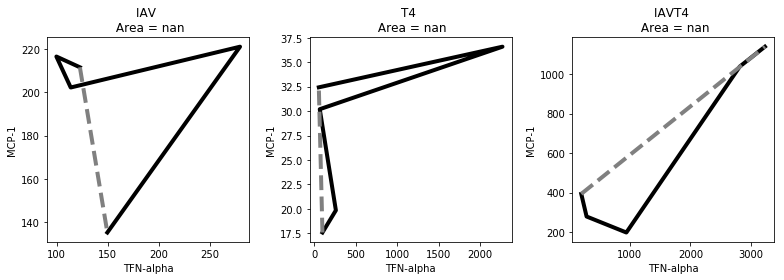

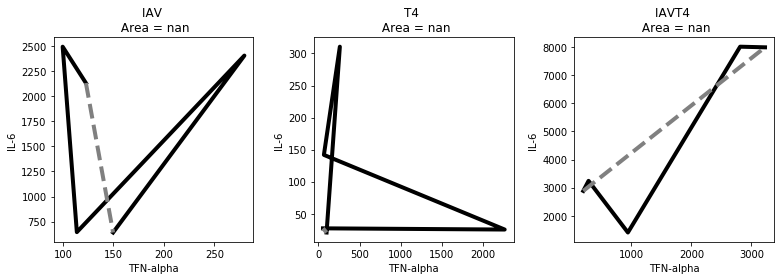

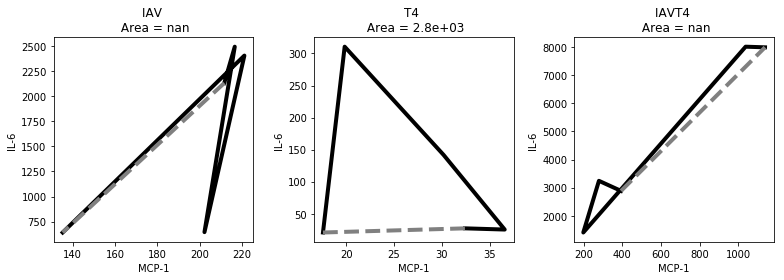

In [40]:
df_list = [IAV, T4, IAVT4]
df_names = ['IAV', 'T4', 'IAVT4']
polygon_plot(df_list, df_names, features[1:7], share_yaxes=False, save=False)

# Supplementary figure 2 - Analysis of simplicial complexes of the IAV + T4 infection group colored by feature
More information may be gathered from the simplicial complexes if they are color coded according to the feature values. The Kepler Mapper colors a vertex of a simplicial complexes according to the average value of the data points that belong to that cluster.

Here we take the simplicial complexes of the IAV + T4 infection group that are generated with lens 2 = viral load or bacterial burden and we color them according to the values of the following features: viral load, bacterial burden, IFN-gamma, IL-6, TNF-alpha, MCP-1.



In [41]:
# define parameter values for the simplicial complexes generated by lens2 = viral load or bacterial burden only
feature_lenses = ["lens_{}".format(x) for x in features[1:3]] 
hypercubes = [[1,13],[3,7]]
p_overlap = [[0.3,0.8],[0.7,0.7]]
eps = [0.5,0.5]
parameter_values = list(zip(feature_lenses, hypercubes, p_overlap, eps))
parameter_values

[('lens_viral load lung', [1, 13], [0.3, 0.8], 0.5),
 ('lens_bacterial burden lung', [3, 7], [0.7, 0.7], 0.5)]

In [42]:
# make data into np array
X = np.array(IAVT4[features[1:]])

# define lenses
lenses_features = def_lenses_features(IAVT4, features[1:])
lenses_nbrs = def_lenses_neighbours(IAVT4, features[1:], labels_IAVT4, metric = 'correlation')

for idx, vals in enumerate(parameter_values): 

    # Combine lenses
    lens = np.c_[lenses_nbrs['Neighbour_1'], lenses_features[vals[0]]]

    # construct simplicial complex
    scomplex = mapper.map(lens, 
                          X, 
                          cover=km.cover.Cover(n_cubes=[vals[1][0], vals[1][1]],perc_overlap=[vals[2][0], vals[2][1]]),
                          clusterer=DBSCAN(metric='correlation', eps=vals[-1], min_samples=1),
                          precomputed=False)


    # visualise

    meta_dict = {"PROJECTIONS":"[neighbour-1, {}]".format(features[idx+1]),
                     "n_cubes":"[{},{}]".format(vals[1][0], vals[1][1]),
                     "PERCENTAGE OVERLAP":"[{},{}]".format(vals[2][0], vals[2][1]),
                     "CLUSTERER":DBSCAN(metric='correlation', eps=vals[-1], min_samples=1),
                     "SCALER":"MinMaxScaler(reature_range=(0,1))"}

    for f in features[1:7]:
        path = "./IAVT4_{}_color_by_{}.html".format(features[idx+1], f)
        _ = mapper.visualize(graph=scomplex, 
                         path_html=path, 
                         custom_meta=meta_dict,                    
        #                  custom_tooltips=labels_IAVT4, 
                         color_function=IAVT4[f].as_matrix().reshape(-1,1),#labels_IAVT4,
                         nbins=5, 
                         title="IAVT4 - lens2 = {} - color by {}".format(features[idx+1], f))


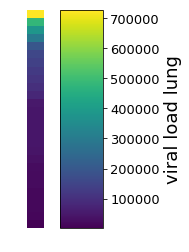

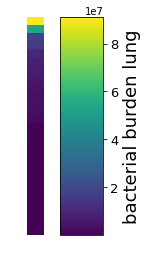

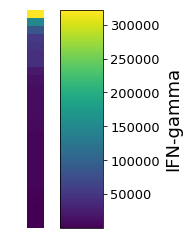

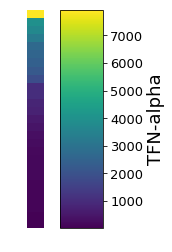

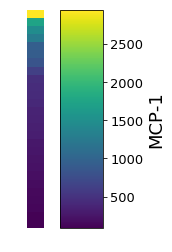

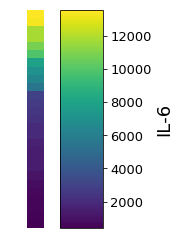

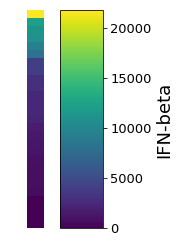

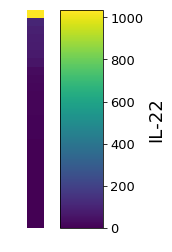

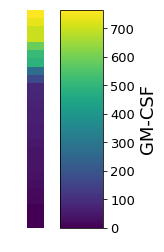

In [43]:
# export the color maps for the feature values
for feature in features[1:]:
    gradient = IAVT4[feature].sort_values(ascending=False).as_matrix().reshape(-1,1)
    gradient = np.hstack((gradient, gradient))
    fig, axes = plt.subplots()
    plt.imshow(gradient)
    cbar = plt.colorbar(aspect=5)
    cbar.set_label('{}'.format(feature),size=18)
    cbar.ax.tick_params(labelsize=13) 
    plt.axis('off')
    plt.savefig('./color_by_feature_colormap_{}'.format(feature),  bbox_inches='tight')

# Figure 7 - Quantification of observations of simplicial complexes, using box plots

In Figure 2 in the main script, we identified interesting regions in some of the simplicial complexes, indicated by the circles. Here we quantify, using box plots, the data points belonging to those groups of points.

We quantify specifically the simplicial complexes of the four data sets corresponding to `lens2 = IL-6`. However, note that any of the other topological networks could also be analysed in the same way, as by checking which data points correspond to each region in the topological graphs (using the html file), we see that they all reveal a similar group of points in each region. 

## All three infection groups put together (data set 4)
Here we separate the group in yellow from the group in teal/purple, and make box plots to compare the of the point belonging to the IAV + T4 infection group that belong to the yellow and the teal/purple regions of the simplicial complex.

#### Observations from the boxplots below
1. The box plot makes it clear that data points from 26 and 31 hours post co-infection are separated by the simplicial complex from the earlier data points.
2. 18 and 26 hpc seem to be a transition point for the system, since at both time points there are data points in both groups (the yellow and the teal/purple).

In [44]:
# index number of data points corresponding to IAV
data[data['infection group']=='IAV'].index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27],
           dtype='int64')

In [45]:
# index number of data points corresponding to T4
data[data['infection group']=='T4'].index

Int64Index([28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
            45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55],
           dtype='int64')

In [46]:
# index number of data points corresponding to IAV + T4
data[data['infection group']=='IAV + T4'].index

Int64Index([56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
            73, 74, 75, 76, 77, 78, 79, 80, 81, 82],
           dtype='int64')

In [47]:
# index number of data points corresponding to each group identified in the simplicial complex of the full data set;
# you can check these by looking at the tooltip labels of each cluster in the html file

# G1: IAV + T4, yellow
idx_g1 = np.array([71, 76, 78, 80, 81, 77, 75, 79, 73, 82]) 

# G2: IAV, T4, AIV + T4 blue and purple
idx_g2 = np.array([x for x in np.arange(len(data)) if x not in idx_g1])

In [48]:
# raw data points in each group identified in the simplicial complex
sc_g1 = data.loc[idx_g1,:]
sc_g2 = data.loc[idx_g2,:]

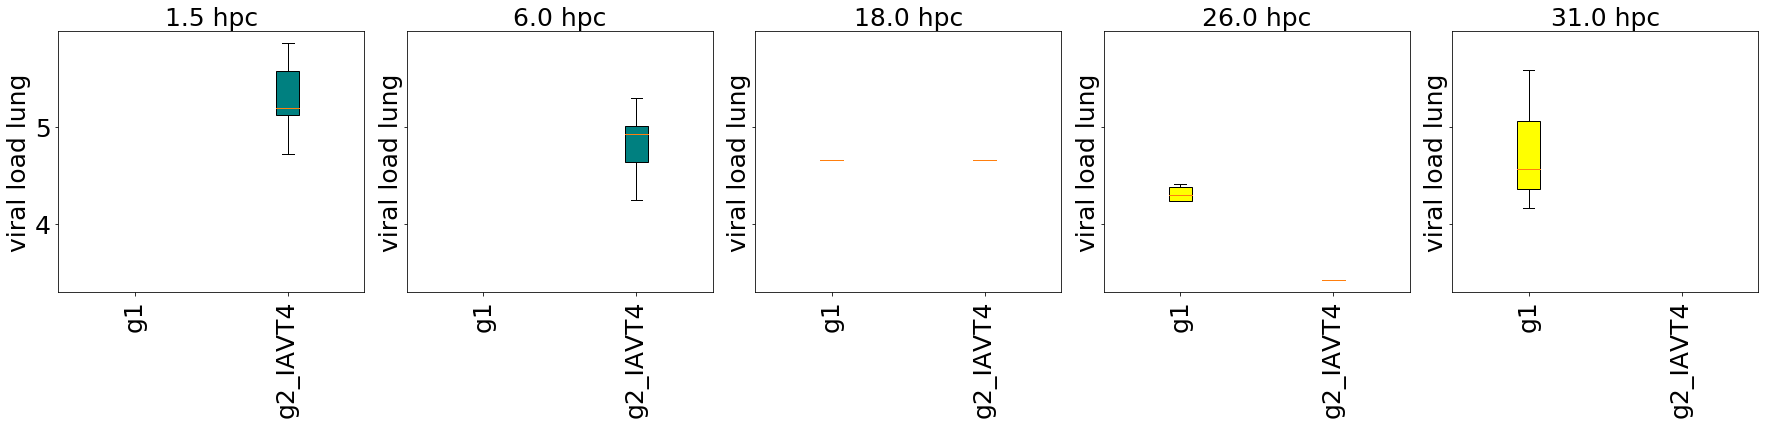

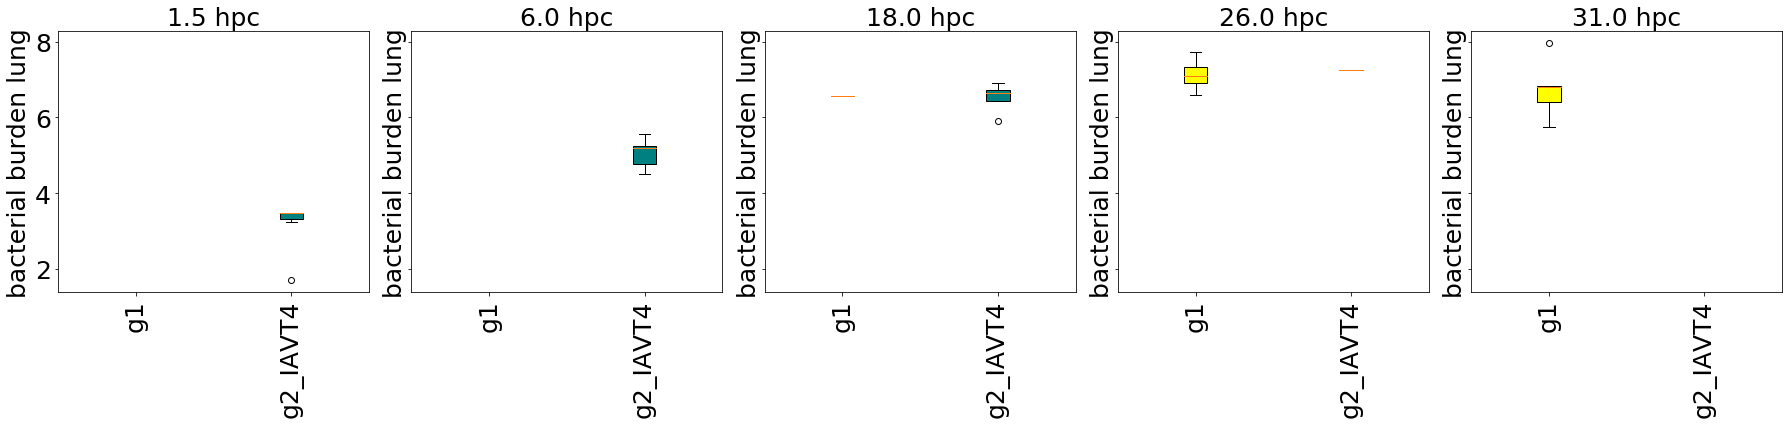

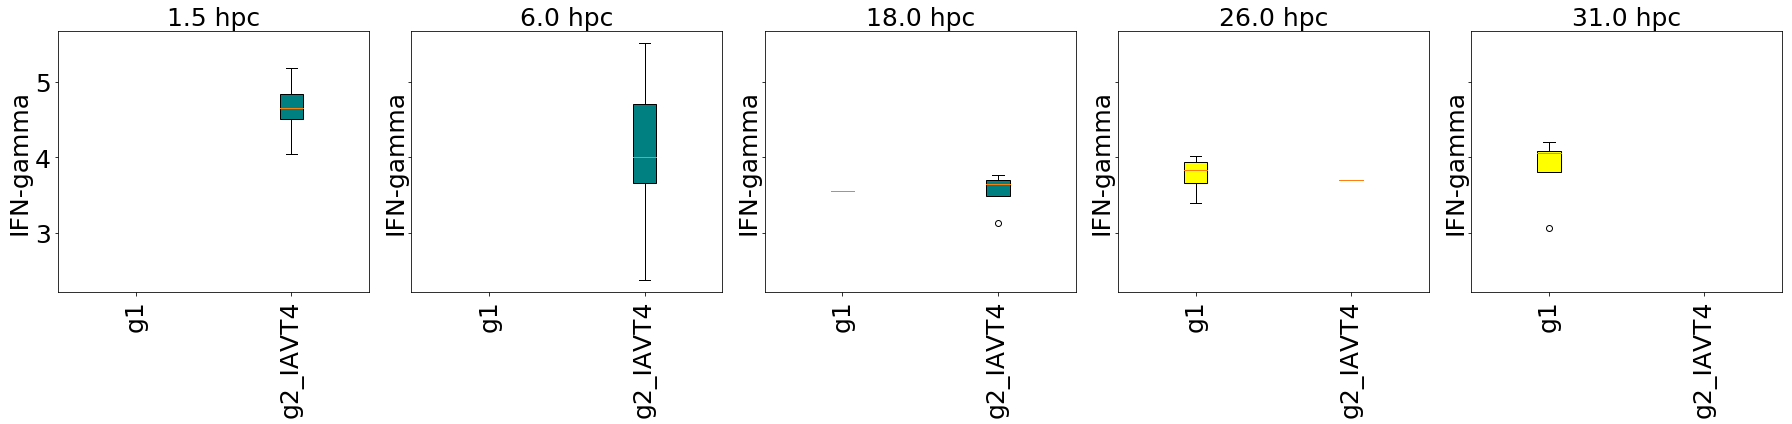

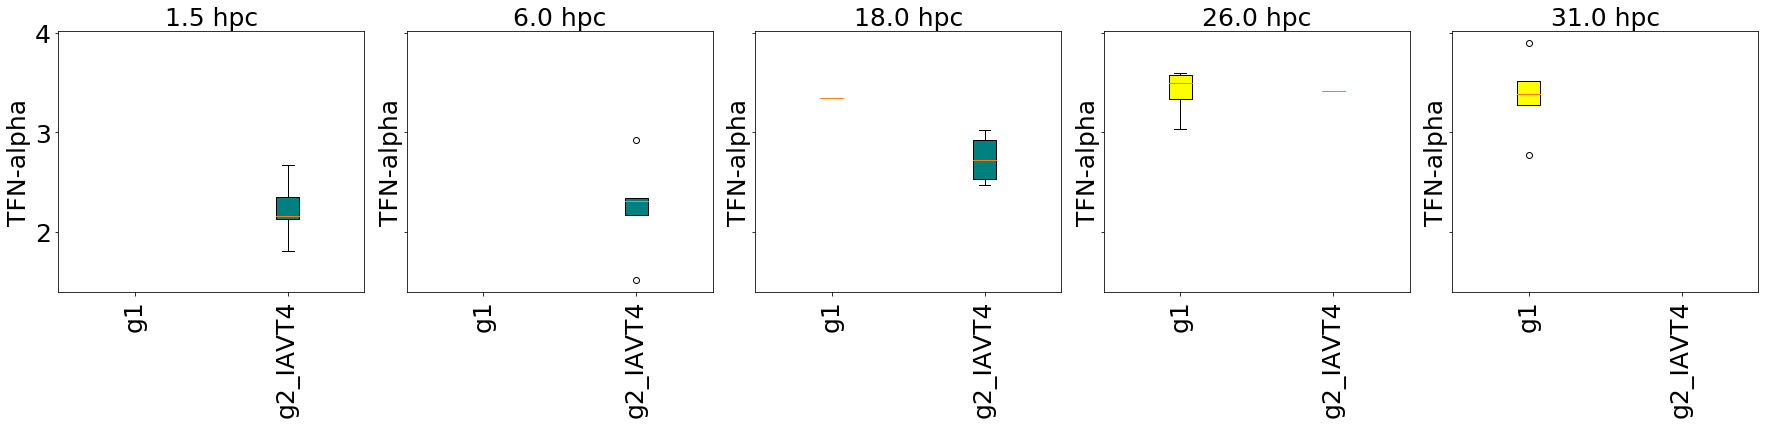

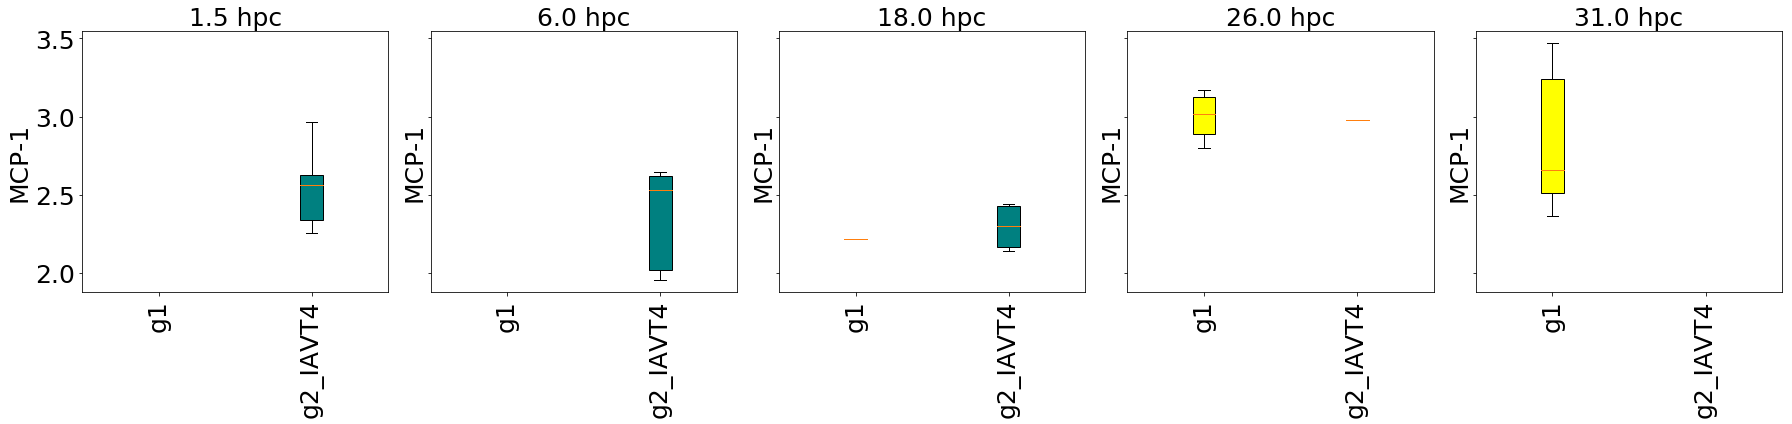

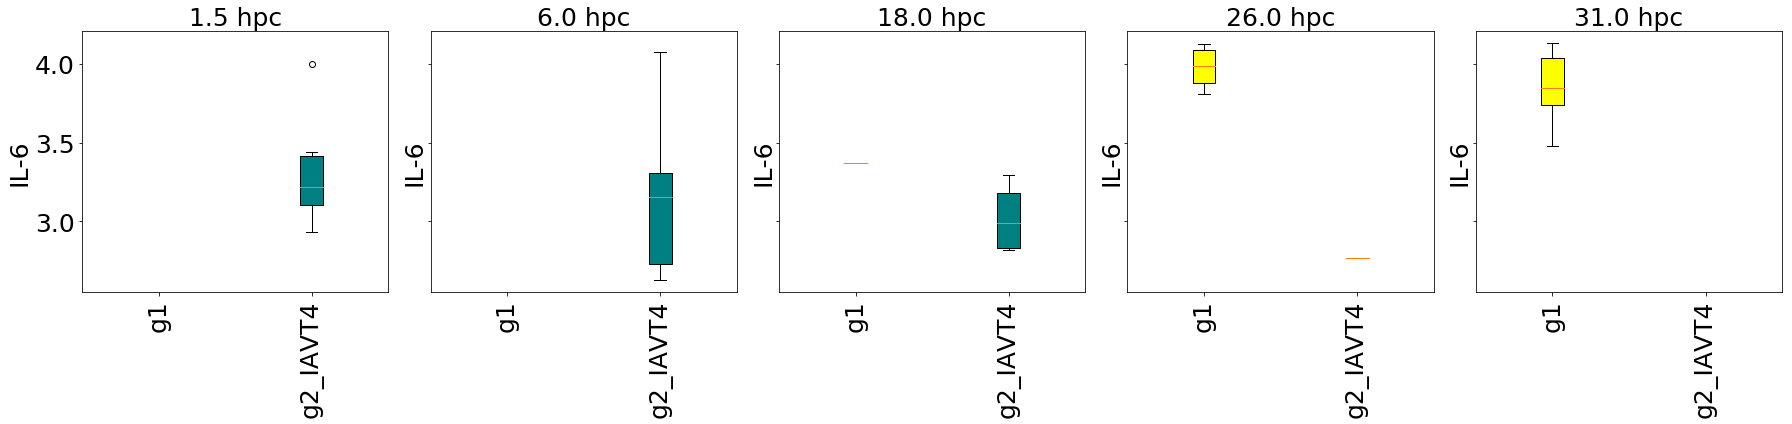

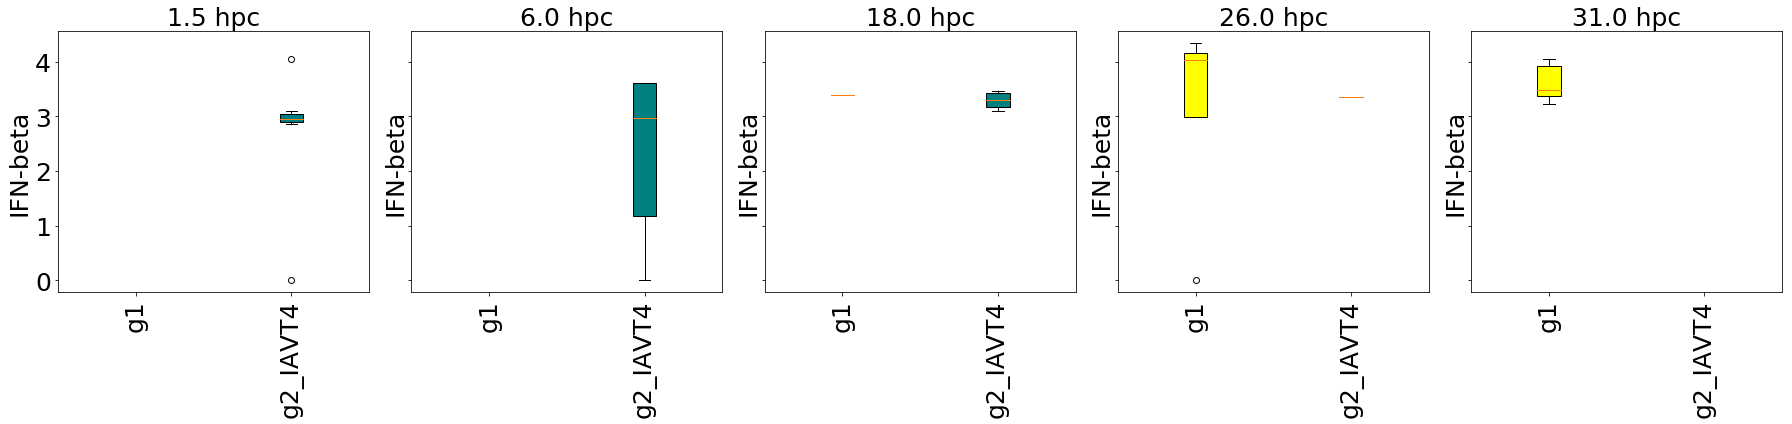

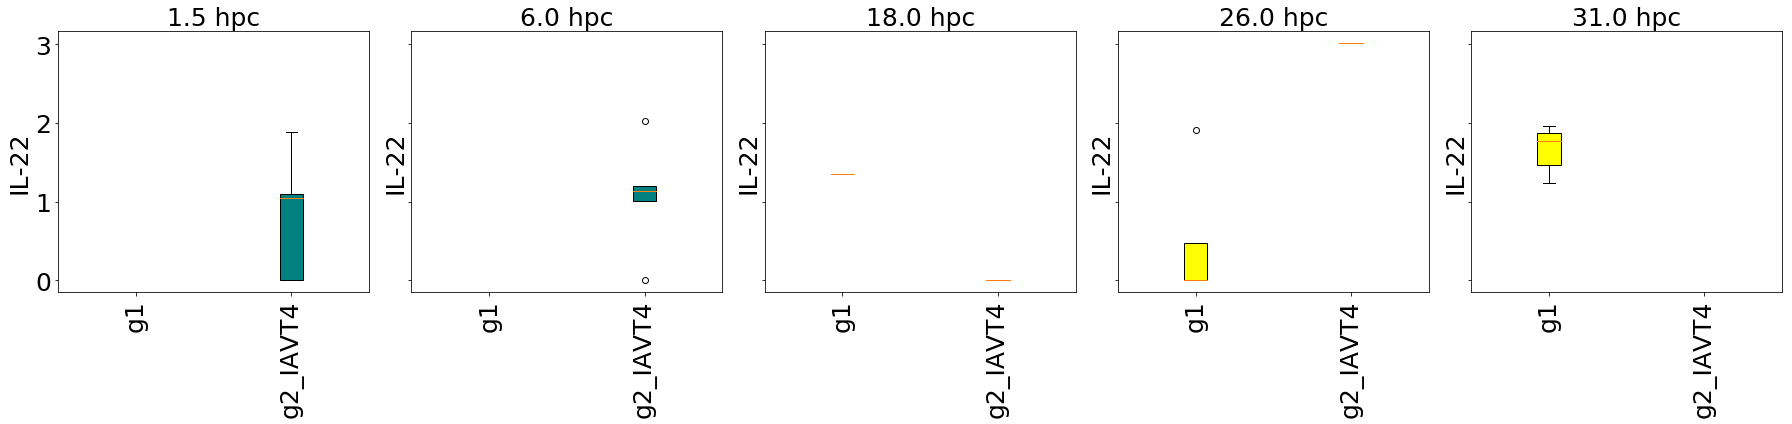

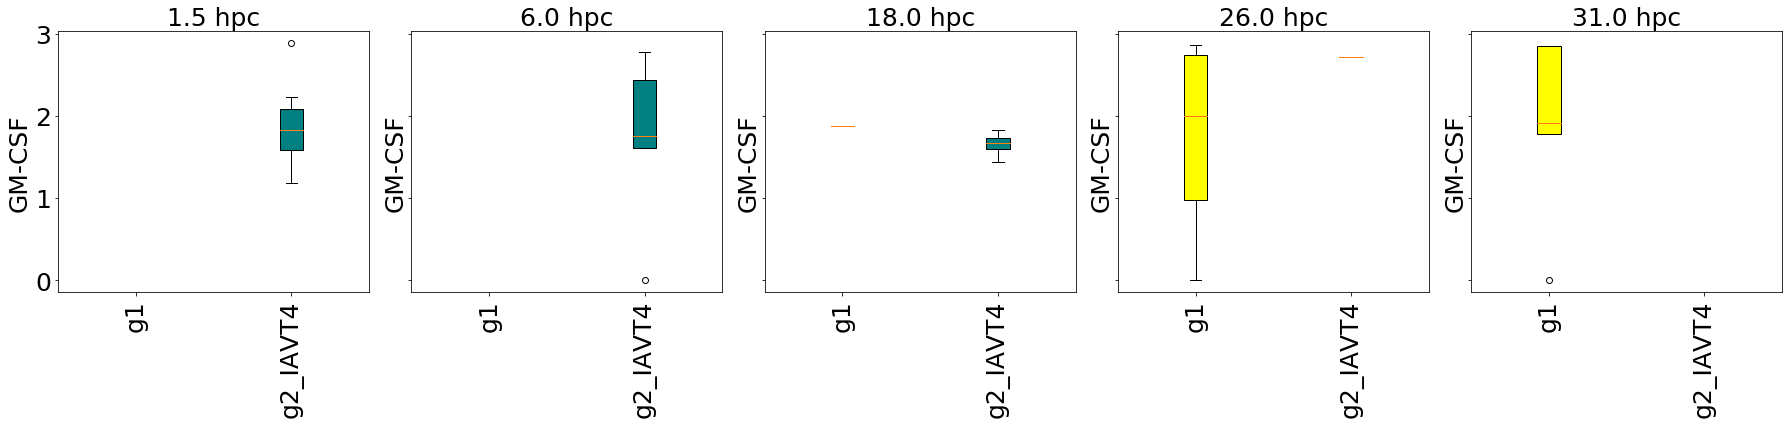

In [49]:
# comparing data points of IAV + T4 that belong to g1 and g2 
# in yellow is IAV + T4 in g1 and in teal is IAV + T4 in g2
# box plots per feature (rows), per time point (columns)

for i,col in enumerate(features[1:]):
    
    fig, axs = plt.subplots(1, len(data['time point'].unique()), figsize=(25,6), sharey=True)

    g1 = sc_g1
    g2_IAVT4 = sc_g2.loc[56:,:]
    
    for timeidx, time in enumerate(data['time point'].unique()):
        
        # define data to plot
        a = np.log10(g1[g1['time point']==time][col])
        d = np.log10(g2_IAVT4[g2_IAVT4['time point']==time][col])
           
        a[np.isinf(a)] = 1*10**(-300)
        d[np.isinf(d)] = 1*10**(-300)
        
        data_to_plot = [a,d]

        # plot
        bplot = axs[timeidx].boxplot(data_to_plot, patch_artist=True)

        for patch, color in zip(bplot['boxes'], ['yellow',                          
                                                 'teal',
                                                ]):
            patch.set_facecolor(color)

        axs[timeidx].set_xticklabels(['g1', 'g2_IAVT4'], rotation=90, fontsize=25)
        axs[timeidx].set_ylabel('{}'.format(col), fontsize=25)
        axs[timeidx].set_title("{} hpc".format(time), fontsize=25)
        axs[timeidx].yaxis.set_tick_params(labelsize=25)

    plt.tight_layout()
    plt.savefig('./boxplot_data_sc_groups_IAVT4_{}'.format(col))

    

# Table 2 - p-values of features between consecutive time points

Here we make box plots as above and in adition we calculate the p-values between groups of data points that belong to the same feature and consecutive time points.

### IAV
As illustrated in the TDA figure above, the simplicial complexes of each feature separates the data points with times 26 and 31 hpc from the earlier data points. Here we make box plots to see if there is a significant difference in the concentration of the cytokines, between earlier time points (1.5, 6, 18 hpc) and later time points (26, 31 hpc), which could explain why the TDA reveals this structure for the IAV infection group data set.

In [50]:
IAV_early = IAV.iloc[:16].copy(deep=True)
IAV_late = IAV.iloc[16:].copy(deep=True)

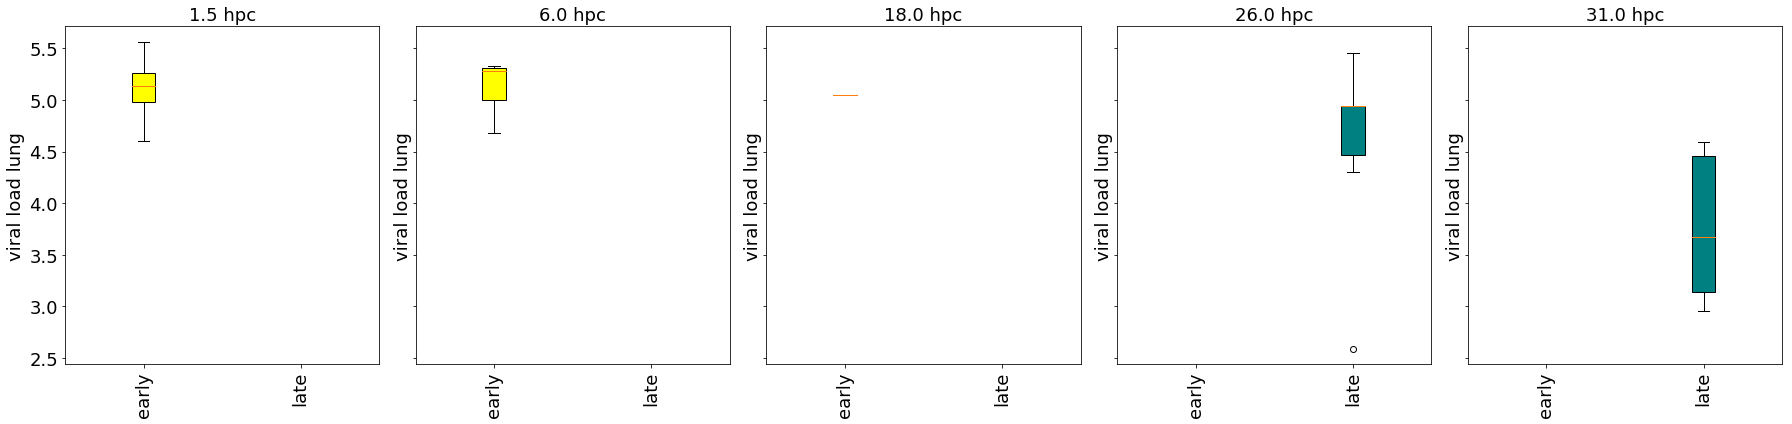

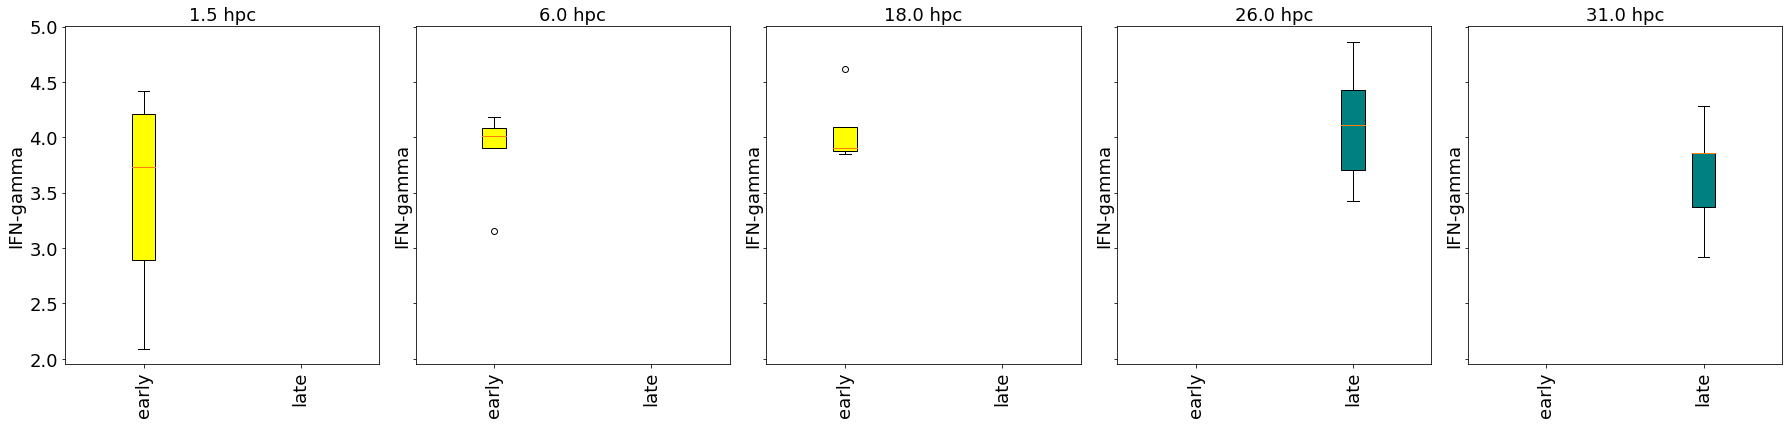

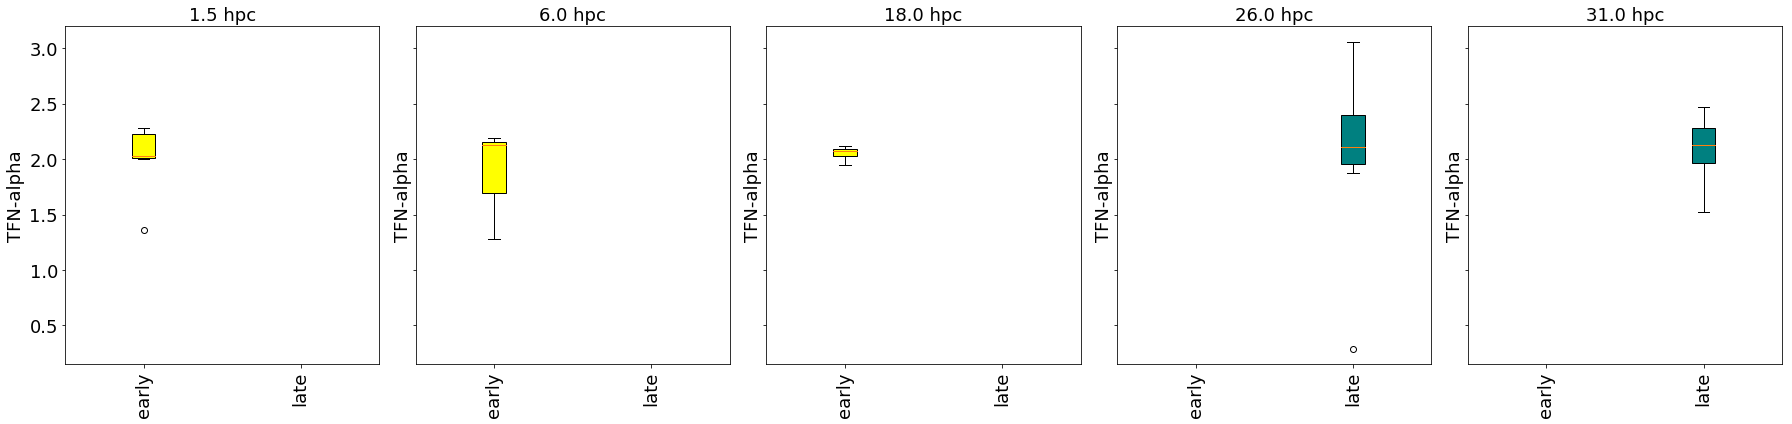

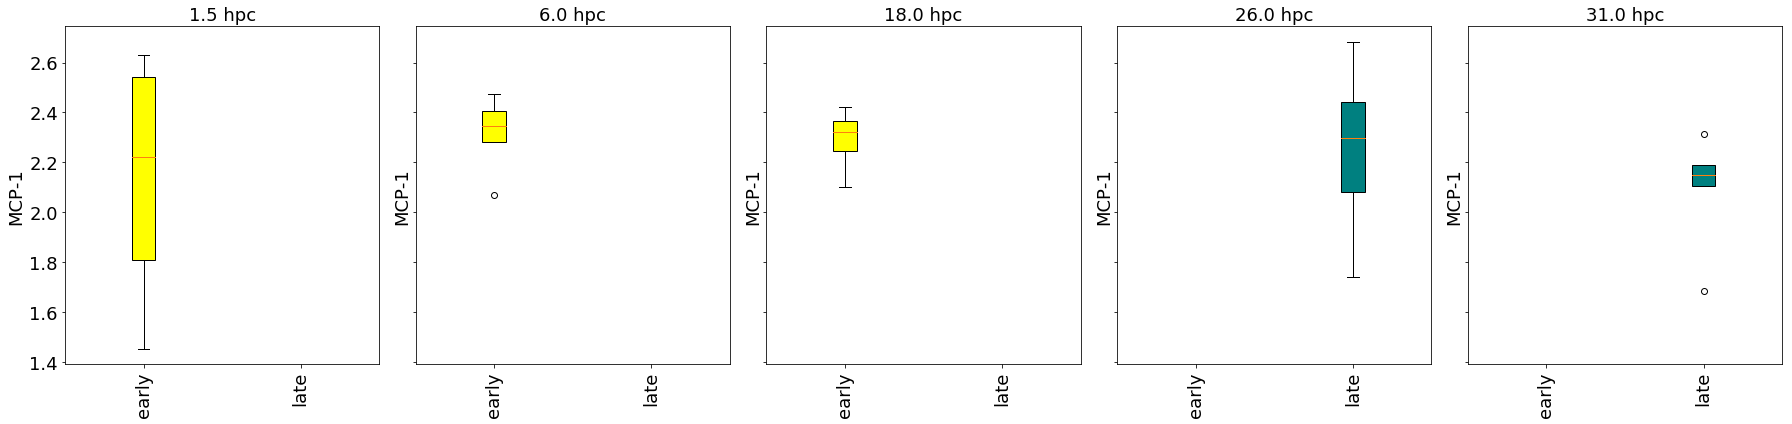

In [51]:
# box plots comparing data points of IAV + T4 grouped together by the simplicial complex, per feature, per time point

for i,col in enumerate(features_no_b[1:5]):
    
    fig, axs = plt.subplots(1, len(data['time point'].unique()), figsize=(25,6), sharey=True)

    for timeidx, time in enumerate(data['time point'].unique()):
        
        # define data to plot
        a = np.log10(IAV_early[IAV_early['time point']==time][col])
        d = np.log10(IAV_late[IAV_late['time point']==time][col])
           
        a[np.isinf(a)] = 1*10**(-300)
        d[np.isinf(d)] = 1*10**(-300)
        
        data_to_plot = [a,d]

        # plot
        bplot = axs[timeidx].boxplot(data_to_plot, patch_artist=True)

        for patch, color in zip(bplot['boxes'], ['yellow',
                                                 'teal', 
                                                ]):
            patch.set_facecolor(color)

        axs[timeidx].set_xticklabels(['early', 'late'], rotation=90, fontsize=18)
        axs[timeidx].set_ylabel('{}'.format(col), fontsize=18)
        axs[timeidx].set_title("{} hpc".format(time), fontsize=18)
        axs[timeidx].yaxis.set_tick_params(labelsize=18)

    plt.tight_layout()
#     plt.savefig('./boxplots_IAV_sc_groups_{}'.format(col))

    

#### p-values between the time points
These values can help us see if there is a significant difference in the mean concentration of each features between the time points. 

In [52]:
p_vals_IAV_df = []

for feature in features[1:]:
    p_vals_IAV_df_temp = []
    for idx in np.arange(len(data['time point'].unique())-1):
        p_vals_IAV_df_temp.append(stats.ttest_ind(IAV[IAV['time point']==data['time point'].unique()[idx]][feature], IAV[IAV['time point']==data['time point'].unique()[idx+1]][feature])[-1])
    p_vals_IAV_df.append(np.array(p_vals_IAV_df_temp))

np.shape(p_vals_IAV_df)

columns = ['1.5v6', '6v18', '18v26', '26v31']    
p_vals_IAV_df = pd.DataFrame(data=p_vals_IAV_df, columns=columns, index=features[1:])
p_vals_IAV_df.drop(inplace=True, index=['IFN-beta','IL-22','GM-CSF'])
p_vals_IAV_df

,1.5v6,6v18,18v26,26v31
viral load lung,0.912720,0.336585,0.607451,0.124077
bacterial burden lung,NaN,NaN,NaN,NaN
IFN-gamma,0.925580,0.425324,0.685015,0.233908
TFN-alpha,0.521103,0.673792,0.428918,0.489646
MCP-1,0.951823,0.747659,0.812167,0.241850
IL-6,0.725286,0.017479,0.143132,0.097698


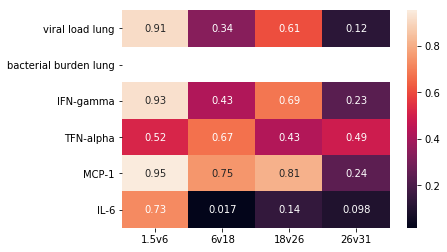

In [53]:
sns.heatmap(p_vals_IAV_df, annot=True)


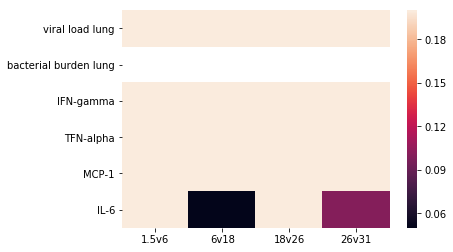

In [54]:
# black indicates p-values <=0.05
# purple indicates p-values 0.05 < p_val <= 0.1
# cream indicates p-values > 0.1

d = p_vals_IAV_df.copy(deep=True)
d = d.as_matrix()
d[d>0.1]=0.2
d[d<=0.05]=0.05
d[np.logical_and(d>0.05,d<=0.1)]=0.1
d = pd.DataFrame(data=d, columns=p_vals_IAV_df.columns, index=p_vals_IAV_df.index)
sns.heatmap(d, annot=False)


#### Observations
The two images above show that there is not a significant difference for any of the features, except for IL-6 as it goes from 6 hpc to 18 hpc and again from 26 hpc to 31 hpc.

### T4
As illustrated in the TDA figure above, the simplicial complexes of each TFN-alpha separate the data points with times 26 and 31 hpc from the earlier data points. 

In [55]:
T4_early = T4.iloc[:16].copy(deep=True)
T4_late = T4.iloc[16:].copy(deep=True)

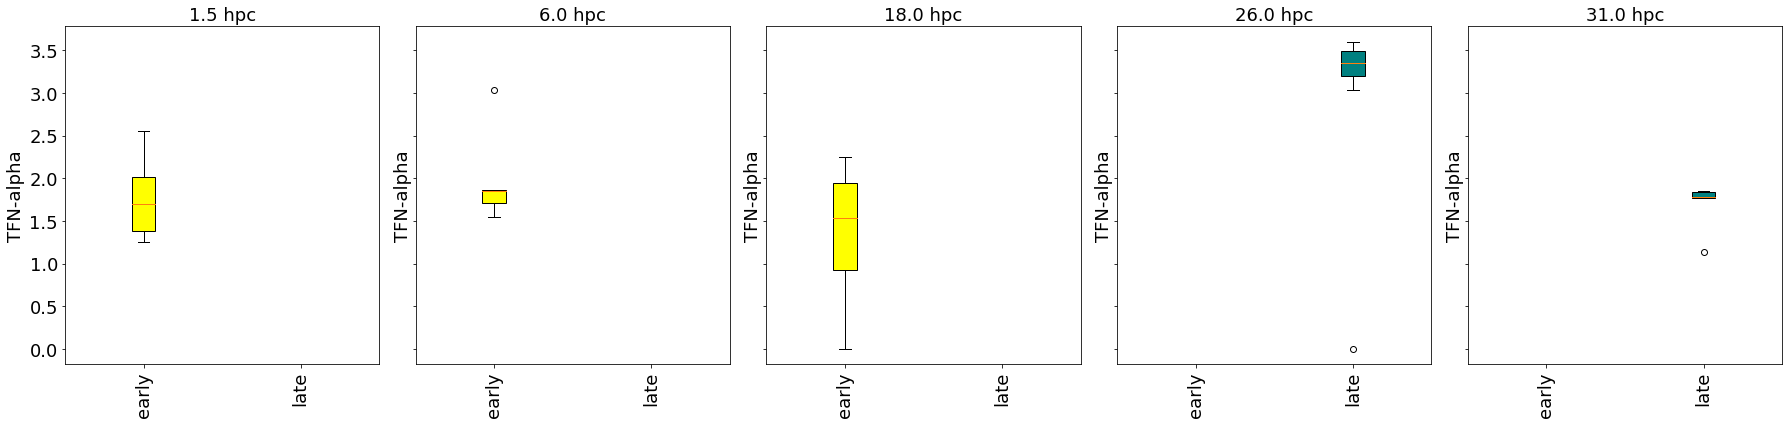

In [56]:
# box plots comparing data points of IAV + T4 grouped together by the simplicial complex, per feature, per time point

for i,col in enumerate([features_no_v[3]]):
    
    fig, axs = plt.subplots(1, len(data['time point'].unique()), figsize=(25,6), sharey=True)

    for timeidx, time in enumerate(data['time point'].unique()):
        
        # define data to plot
        a = np.log10(T4_early[T4_early['time point']==time][col])
        d = np.log10(T4_late[T4_late['time point']==time][col])
           
        a[np.isinf(a)] = 1*10**(-300)
        d[np.isinf(d)] = 1*10**(-300)
        
        data_to_plot = [a,d]

        # plot
        bplot = axs[timeidx].boxplot(data_to_plot, patch_artist=True)

        for patch, color in zip(bplot['boxes'], ['yellow',
                                                 'teal', 
                                                ]):
            patch.set_facecolor(color)

        axs[timeidx].set_xticklabels(['early', 'late'], rotation=90, fontsize=18)
        axs[timeidx].set_ylabel('{}'.format(col), fontsize=18)
        axs[timeidx].set_title("{} hpc".format(time), fontsize=18)
        axs[timeidx].yaxis.set_tick_params(labelsize=18)

    plt.tight_layout()
#     plt.savefig('./boxplot_T4_sc_groups_{}'.format(col))

    

#### p-values between the time points
These values can help us see if there is a significant difference in the mean concentration of each features between the time points. 

In [57]:
p_vals_T4_df = []

for feature in features[1:]:
    p_vals_T4_df_temp = []
    for idx in np.arange(len(data['time point'].unique())-1):
        p_vals_T4_df_temp.append(stats.ttest_ind(T4[T4['time point']==data['time point'].unique()[idx]][feature], T4[T4['time point']==data['time point'].unique()[idx+1]][feature])[-1])
    p_vals_T4_df.append(np.array(p_vals_T4_df_temp))

np.shape(p_vals_T4_df)

columns = ['1.5v6', '6v18', '18v26', '26v31']    
p_vals_T4_df = pd.DataFrame(data=p_vals_T4_df, columns=columns, index=features[1:])
p_vals_T4_df.drop(inplace=True, index=['IFN-beta','IL-22','GM-CSF'])
p_vals_T4_df

,1.5v6,6v18,18v26,26v31
viral load lung,NaN,NaN,NaN,NaN
bacterial burden lung,0.256184,0.409712,0.484568,0.683890
IFN-gamma,0.077142,0.186519,0.433551,0.963571
TFN-alpha,0.382180,0.432187,0.012964,0.005679
MCP-1,0.815624,0.618153,0.871879,0.900667
IL-6,0.246575,0.634608,0.236886,0.928624


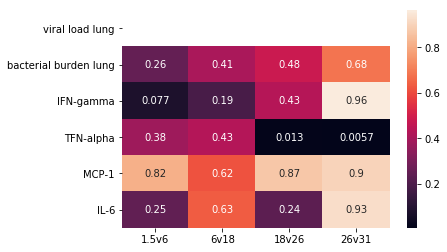

In [59]:
sns.heatmap(p_vals_T4_df, annot=True)


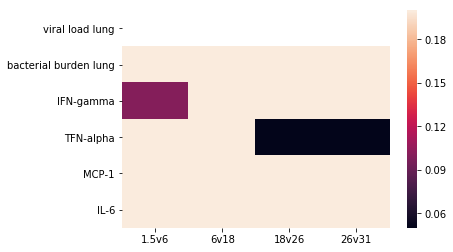

In [60]:
# black indicates p-values <=0.05
# purple indicates p-values 0.05 < p_val <= 0.1
# cream indicates p-values > 0.1

d = p_vals_T4_df.copy(deep=True)
d = d.as_matrix()
d[d>0.1]=0.2
d[d<=0.05]=0.05
d[np.logical_and(d>0.05,d<=0.1)]=0.1
d = pd.DataFrame(data=d, columns=p_vals_T4_df.columns, index=p_vals_T4_df.index)
sns.heatmap(d, annot=False)


#### Observations
The two images above show that there a significant change in IFN-gamma between 1.5 and 6 hpc and in TFN-alpha between 18 and 26 hpc and again between 26 and 31 hpc.

### IAV + T4
As illustrated in figure 2 in the main script, the simplicial complexes of each TFN-alpha separate the data points with times 26 and 31 hpc from the earlier data points. 

In [61]:
IAVT4_early = IAVT4.iloc[:16].copy(deep=True)
IAVT4_late = IAVT4.iloc[16:].copy(deep=True)

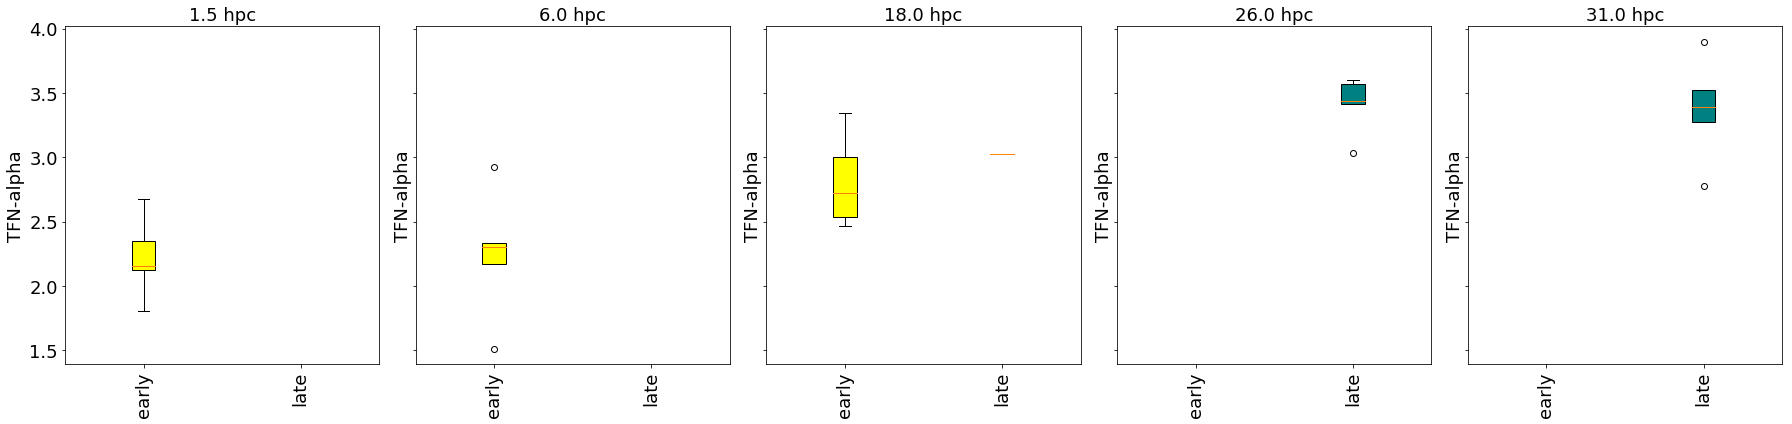

In [62]:
# box plots comparing data points of IAV + T4 grouped together by the simplicial complex, per feature, per time point

for i,col in enumerate([features[4]]):
    
    fig, axs = plt.subplots(1, len(data['time point'].unique()), figsize=(25,6), sharey=True)

    for timeidx, time in enumerate(data['time point'].unique()):
        
        # define data to plot
        a = np.log10(IAVT4_early[IAVT4_early['time point']==time][col])
        d = np.log10(IAVT4_late[IAVT4_late['time point']==time][col])
           
        a[np.isinf(a)] = 1*10**(-300)
        d[np.isinf(d)] = 1*10**(-300)
        
        data_to_plot = [a,d]

        # plot
        bplot = axs[timeidx].boxplot(data_to_plot, patch_artist=True)

        for patch, color in zip(bplot['boxes'], ['yellow',
                                                 'teal', 
                                                ]):
            patch.set_facecolor(color)

        axs[timeidx].set_xticklabels(['early', 'late'], rotation=90, fontsize=18)
        axs[timeidx].set_ylabel('{}'.format(col), fontsize=18)
        axs[timeidx].set_title("{} hpc".format(time), fontsize=18)
        axs[timeidx].yaxis.set_tick_params(labelsize=18)

    plt.tight_layout()
#     plt.savefig('./boxplot_IAVT4_sc_groups_{}'.format(col))

    

#### p-values between the time points
These values can help us see if there is a significant difference in the mean concentration of each features between the time points. 

In [63]:
p_vals_IAVT4_df = []

for feature in features[1:]:
    p_vals_IAVT4_df_temp = []
    for idx in np.arange(len(data['time point'].unique())-1):
        p_vals_IAVT4_df_temp.append(stats.ttest_ind(IAVT4[IAVT4['time point']==data['time point'].unique()[idx]][feature], IAVT4[IAVT4['time point']==data['time point'].unique()[idx+1]][feature])[-1])
    p_vals_IAVT4_df.append(np.array(p_vals_IAVT4_df_temp))

np.shape(p_vals_IAVT4_df)

columns = ['1.5v6', '6v18', '18v26', '26v31']    
p_vals_IAVT4_df = pd.DataFrame(data=p_vals_IAVT4_df, columns=columns, index=features[1:])
p_vals_IAVT4_df.drop(inplace=True, index=['IFN-beta','IL-22','GM-CSF'])
p_vals_IAVT4_df

,1.5v6,6v18,18v26,26v31
viral load lung,0.113336,0.202011,0.000101,0.200436
bacterial burden lung,0.009209,0.006859,0.104765,0.958299
IFN-gamma,0.748814,0.269034,0.161643,0.320453
TFN-alpha,0.520351,0.120874,0.016524,0.766774
MCP-1,0.411175,0.353125,0.000691,0.859898
IL-6,0.879291,0.425412,0.019389,0.994039


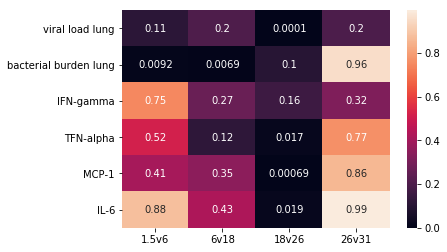

In [65]:
sns.heatmap(p_vals_IAVT4_df, annot=True)


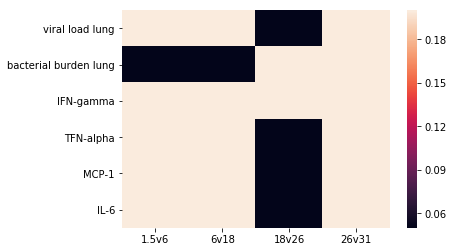

In [66]:
# black indicates p-values <=0.05
# purple indicates p-values 0.05 < p_val <= 0.1
# cream indicates p-values > 0.1

d = p_vals_IAVT4_df.copy(deep=True)
d = d.as_matrix()
d[d>0.1]=0.2
d[d<=0.05]=0.05
d[np.logical_and(d>0.05,d<=0.1)]=0.1
d = pd.DataFrame(data=d, columns=p_vals_IAVT4_df.columns, index=p_vals_IAVT4_df.index)
sns.heatmap(d, annot=False)


#### Observations
The two images above show that there is a significant chance for all the cytokines between 18 hpc and 26 hpc (except IFN-gamma). And that the bacterial burden changes significantly ealier in the infection course (between 1.5 and 18 hpc).